In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
%cd gdrive/My Drive/tpsDeepLearning/

/content/gdrive/My Drive/tpsDeepLearning


In [3]:
!pip install tensorboardX

     |████████████████████████████████| 317kB 8.0MB/s 


### Generative Adversarial Networks (GAN)

L'objectif de ce TP est de créer et manipuler un Generative Adversarial Networks (GAN) afin de générer des images de chiffres manuscrits à partir d'une base de données d'exemples.

Vous aurez besoin des outils présents dans le fichier gan_tools_cuda.py que vous devrez copier dans votre répertoire Jupyter afin de pouvoir l'importer. Regardez bien les fonctions et classes définies dans ce fichier : il y a les codes permettant de télécharger la base de donnée d'images, de faire les conversions entre images et vecteurs, de générer les vecteurs de bruit à donner en entrée du générateur et de gérer l’affichage des résultats sous forme d'exemples d’images générées par le générateur et des indices de qualité du générateur et du discriminateur. 

###### 1. Importation des librairies et de gan_tools_cuda.py

In [4]:
import torch
from torch import nn, optim
from torch.autograd.variable import Variable

import gan_tools_cuda as gt

In [5]:
import os
import numpy as np
import errno
import torchvision.utils as vutils
from torchvision import transforms, datasets
from tensorboardX import SummaryWriter
from IPython import display
from matplotlib import pyplot as plt
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
#import torch
#from torch.autograd.variable import Variable

###### 2. Chargement des données d'apprentissage et création du "loader" 

Le loader présentera au réseau les données par paquet de 100, dans un ordre aléatoire.

In [7]:
DATA_FOLDER = './torch_data/VGAN/MNIST'

def mnist_data():
    compose = transforms.Compose([
        transforms.ToTensor(), transforms.Normalize([0.5], [0.5])])
    out_dir = '{}/dataset'.format(DATA_FOLDER)
    return datasets.MNIST(root=out_dir, train=True, transform=compose, download=True)


In [8]:
batch_size = 100

compose = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5,], [0.5,])])

dataset = MNIST('./data', train=True, transform=compose, download=True)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
num_batches = len(data_loader)

In [9]:
dataset

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=[0.5], std=[0.5])
           )

###### 3. Création du discriminateur

Créez une classe Python DiscriminatorNet décrivant la structure du réseau discriminateur. 

Le réseau est composé de trois couches cachées et d'une couche de sortie. Nous utiliserons le module "séquentiel" de Pytorch qui décrit l’ordre des différentes transformations à appliquer aux données dans chaque couche.

L'entrée du réseau est un vecteur avec 784 valeurs (une image 28x28), la sortie est une valeur unique, allant de 0 (fausse image) à 1 (vraie image) grâce à l'utilisation d'une fonction sigmoïde.

Les trois couches cachées utilisent une fonction LeakyReLU pour transformer leur sortie en valeurs quasi positives, avec alpha = 0,2. Elles utilisent également une fonction Dropout pour définir aléatoirement à zéro 30% des valeurs de sortie des neurones des couches cachées (il a été prouvé que cela augmentait les performances du réseau en empêchant le sur-apprentissage). Le nombre de neurones dans chaque couche cachée est respectivement de 1024, 512 et 256.

La classe possède une méthode "forward" permettant de calculer la sortie du réseau à partir d'un vecteur d'entrée (représenaant une image).

In [10]:
class DiscriminatorNet(torch.nn.Module):

    def __init__(self):
        super(DiscriminatorNet, self).__init__()
        n_features = 784
        n_out = 1
        
        self.hidden0 = nn.Sequential( 
            nn.Linear(n_features, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
      
        self.hidden1 = nn.Sequential( 
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )

        self.hidden2 = nn.Sequential( 
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
            
        self.out = nn.Sequential(
            torch.nn.Linear(256, n_out),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.out(x)
        return x

###### 4. Création du générateur

Créez une classe Python GeneratorNet décrivant la structure du réseau générateurs. Le réseau est composé de trois couches cachées et d'une couche de sortie. L'entrée du réseau est un vecteur avec 100 valeurs, la sortie est une image avec 784 valeurs (utilisez nn.Tanh() au lieu de nn.Sigmoid() pour convertir les valeurs de sortie). Les trois couches cachées utilisent une fonction LeakyReLU pour transformer leur sortie en valeurs quasi positives, avec alpha = 0,2, mais pas de Dropout ici. Le nombre de neurones dans chaque couche cachée est respectivement de 256, 512 et 1024

In [11]:
class GeneratorNet(torch.nn.Module):

    def __init__(self):
        super(GeneratorNet, self).__init__()
        
        n_features = 100
        n_out = 784
        
        self.hidden0 = nn.Sequential( 
            nn.Linear(n_features, 256),
            nn.LeakyReLU(0.2)
        )
      
        self.hidden1 = nn.Sequential( 
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2)
        )

        self.hidden2 = nn.Sequential( 
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2)
        )
            
        self.out = nn.Sequential(
            nn.Linear(1024, n_out),
            nn.Tanh()
        )
    
    def forward(self, x):   
      x = self.hidden0(x)
      x = self.hidden1(x)
      x = self.hidden2(x)
      x = self.out(x)
      return x    

###### 5. Creation du processus d'apprentissage

Initialisez les instances d'un discriminateur et d'un générateurs. Créez deux optimiseurs de type Adam pour les deux réseaux. Définissez la fonction de perte: ici, nous choisissons une fonction d'entropie croisée binaire pour vérifier si le discriminateur trouve la bonne réponse.

In [15]:
discriminator = DiscriminatorNet()
generator = GeneratorNet()
if torch.cuda.is_available():
    discriminator.cuda()
    generator.cuda()
    
# Optimizers
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002)
g_optimizer = optim.Adam(generator.parameters(), lr=0.0002)

# Loss function
loss = nn.BCELoss()

Créez une fonction train_generator et une fonction train_discriminator. 
Expliquez les différentes étapes du processus d'apprentissage.


In [16]:
def train_discriminator(optimizer, real_data, fake_data):
    # Reset gradients
    optimizer.zero_grad()
    
    # 1.1 Train on Real Data
    prediction_real = discriminator(real_data) # prédiction du modèle sur les vraies données
    # Calculate error and backpropagate
    error_real = loss(prediction_real, gt.real_data_target(real_data.size(0)))
    error_real.backward()  # calcule les gradients, ceci permet de savoir dans quelle direction on va ajuster les poids
                          # Esk les poids vont augmenter ou diminuer

    # 1.2 Train on Fake Data
    prediction_fake = discriminator(fake_data) # prédiction  du modèle sur les fausses données
    # Calculate error and backpropagate
    error_fake = loss(prediction_fake, gt.fake_data_target(real_data.size(0)))
    error_fake.backward()  # calcule les gradients, ceci permet de savoir dans quelle direction on va ajuster les poids
                          # Esk les poids vont augmenter ou diminuer
    
    # 1.3 Update weights with gradients
    optimizer.step()
    
    # Return error
    return error_real + error_fake, prediction_real, prediction_fake

In [17]:
def train_generator(optimizer, fake_data):
    # 2. Train Generator
    # Reset gradients
    optimizer.zero_grad()
    # Sample noise and generate fake data
    prediction = discriminator(fake_data)
    # Calculate error and backpropagate
    error = loss(prediction, gt.real_data_target(prediction.size(0)))
    error.backward()
    # Update weights with gradients
    optimizer.step()
    # Return error
    return error

###### 6. Apprentissage et visualisation:

Pour chaque itération et pour chaque lot ("batch") de données, les étapes d'apprentissage sont les suivantes:

 - Transformez le lot de données en variables Torch à l'aide des fonctions Variable et gt.images_to_vectors. Ce sont les vraies données pour l'étape suivante.

 - Créez des vecteurs de bruit de taille 100 avec gt.noise (autant que de vraies images dans le lot), puis générez de fausses données avec le générateur.

 - Former le discriminateur sur les fausses données et les données réelles, en utilisant l'optimiseur défini ci-dessus (d_optimizer).

 - Créez d'autres vecteurs de bruit, taille 100, avec gt.noise.

 - Entrainez le générateur sur les vecteurs de bruit.

 - Visualisez un échantillon d'images générées avec gt.plot_gan. Cette fonction nécessite le numéro d'itération et de lot, ainsi que le nombre total de lots et le nom du générateur.

###### Attention :
Il se peut que le système se "bloque" dans une configuration où la sortie du générateur est la même quelle que soit l'entrée. Si toutes les images des exemples de sortie sont identiques après une dizaine d'itérations et que D(x) = 1 et D(G(z)) = 0, il faut relancer l'apprentissage (redémarrer le noyau).

Epoch: 0, Batch Num: [0/600]


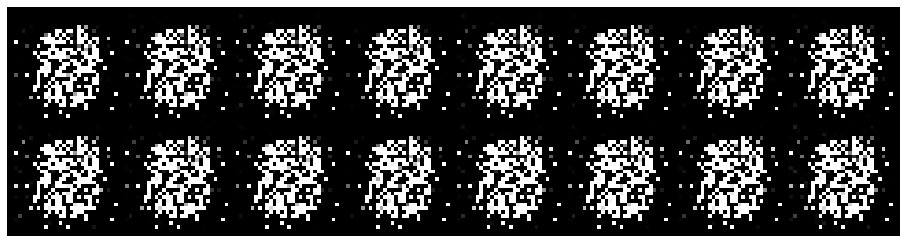

Epoch: 0, Batch Num: [100/600]


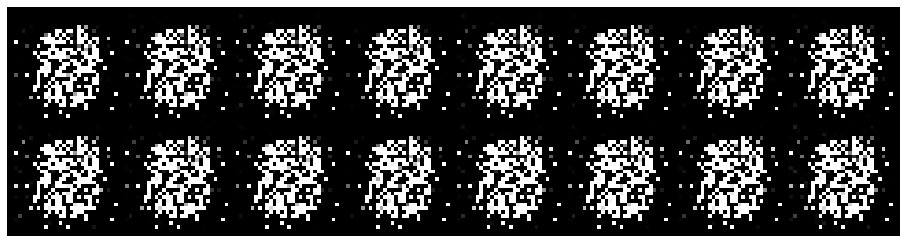

Epoch: 0, Batch Num: [200/600]


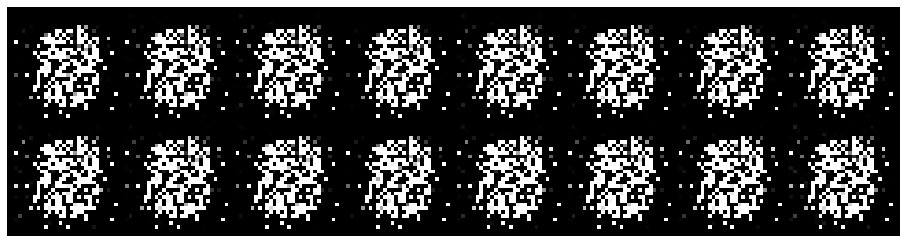

Epoch: 0, Batch Num: [300/600]


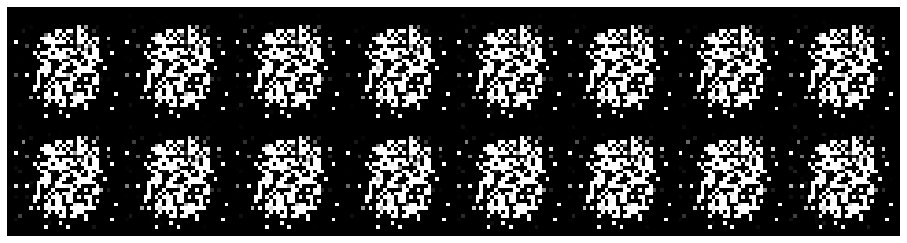

Epoch: 0, Batch Num: [400/600]


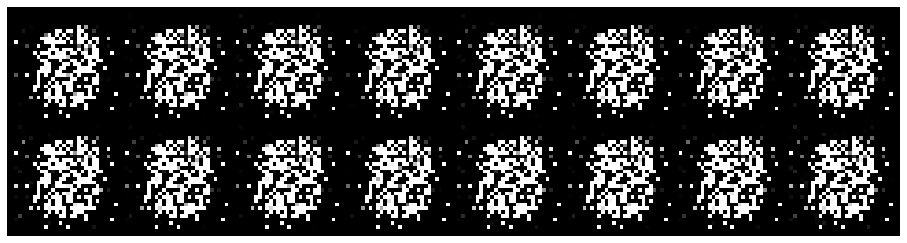

Epoch: 0, Batch Num: [500/600]


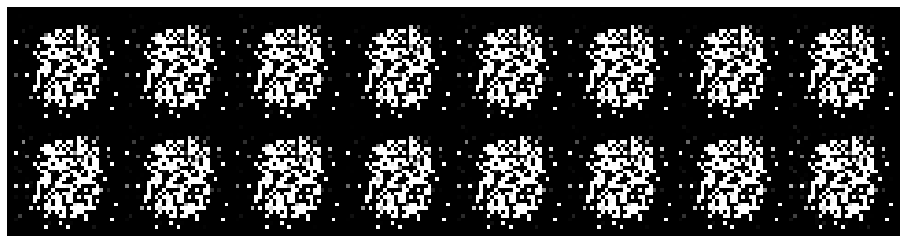

Epoch: 1, Batch Num: [0/600]


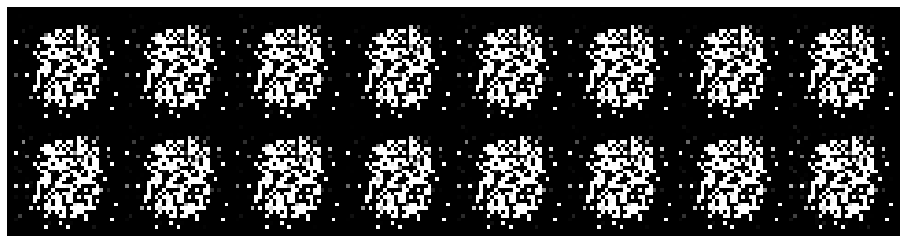

Epoch: 1, Batch Num: [100/600]


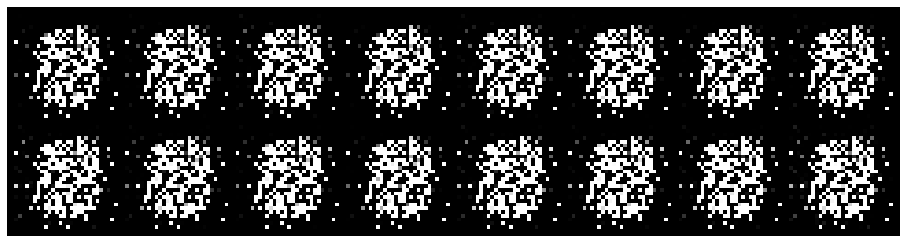

Epoch: 1, Batch Num: [200/600]


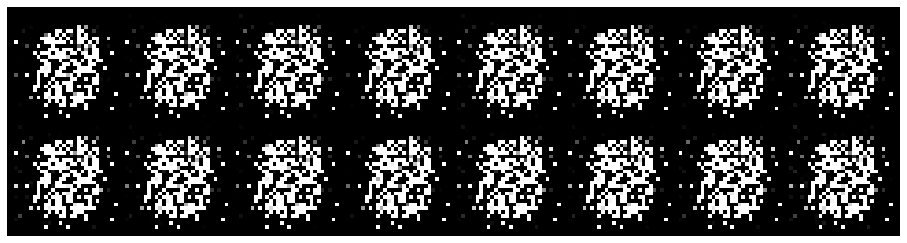

Epoch: 1, Batch Num: [300/600]


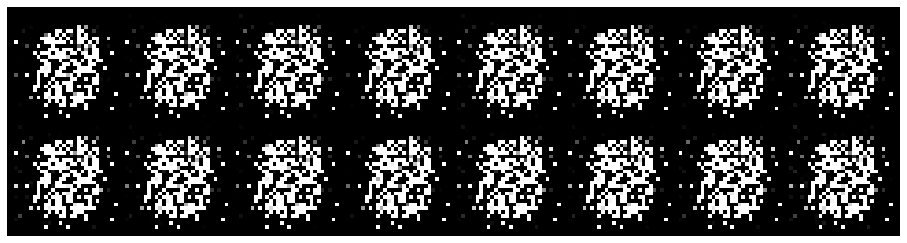

Epoch: 1, Batch Num: [400/600]


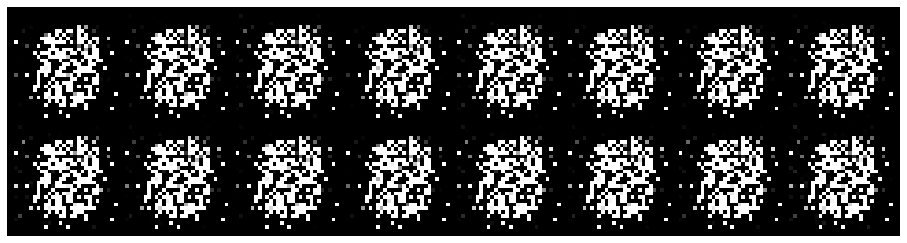

Epoch: 1, Batch Num: [500/600]


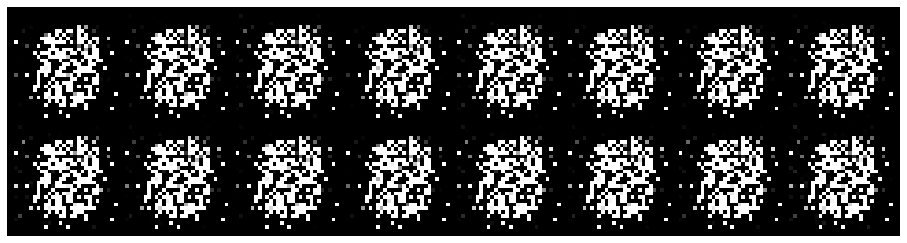

Epoch: 2, Batch Num: [0/600]


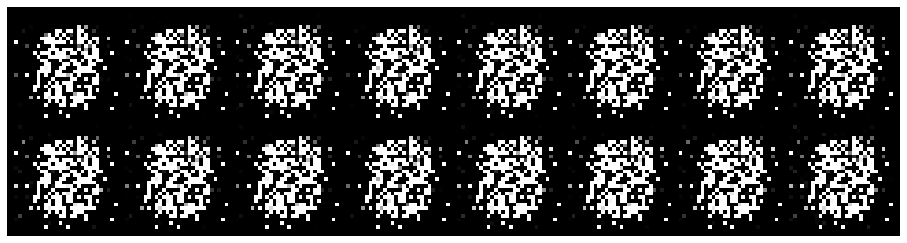

Epoch: 2, Batch Num: [100/600]


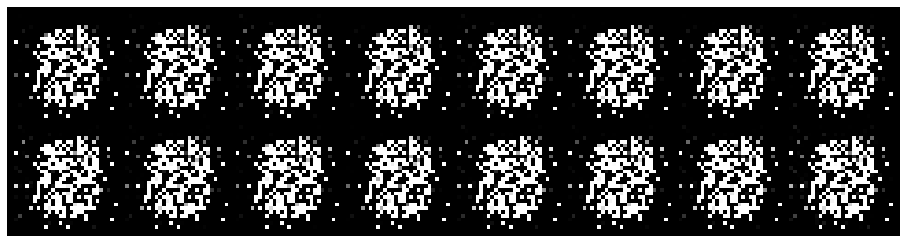

Epoch: 2, Batch Num: [200/600]


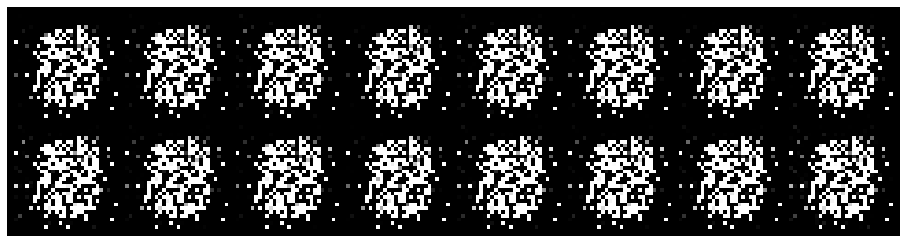

Epoch: 2, Batch Num: [300/600]


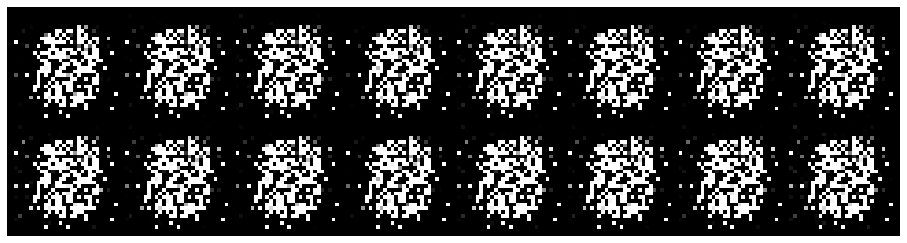

Epoch: 2, Batch Num: [400/600]


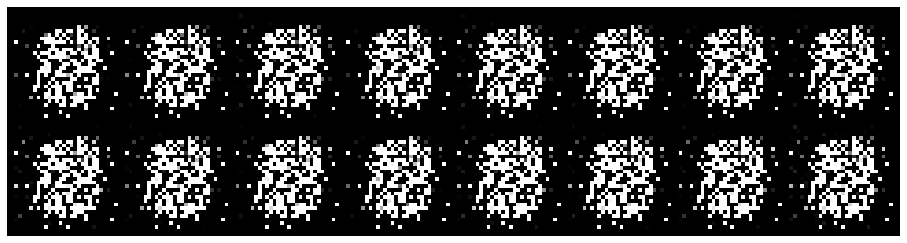

Epoch: 2, Batch Num: [500/600]


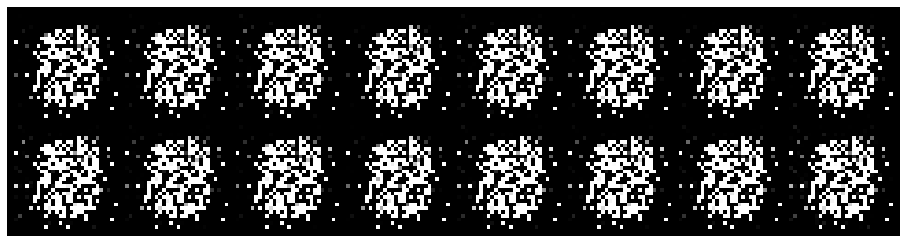

Epoch: 3, Batch Num: [0/600]


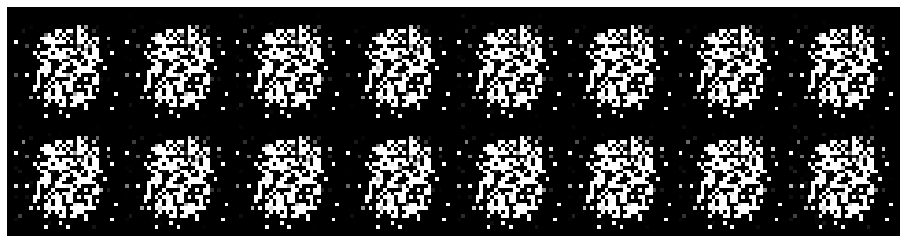

Epoch: 3, Batch Num: [100/600]


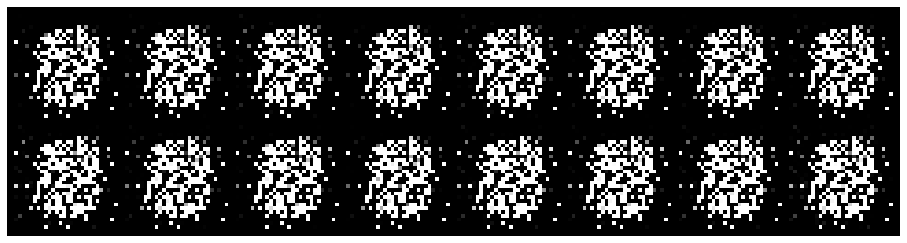

Epoch: 3, Batch Num: [200/600]


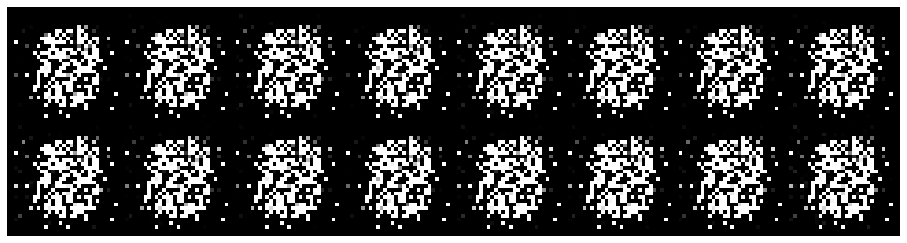

Epoch: 3, Batch Num: [300/600]


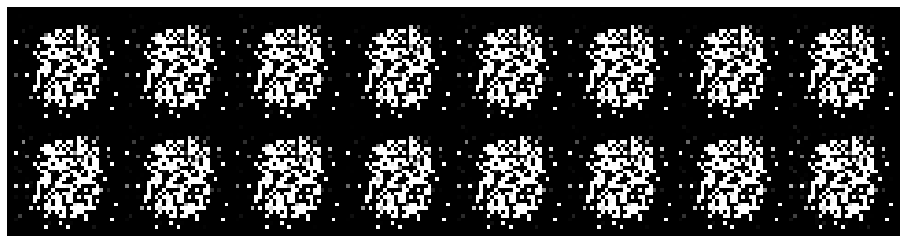

Epoch: 3, Batch Num: [400/600]


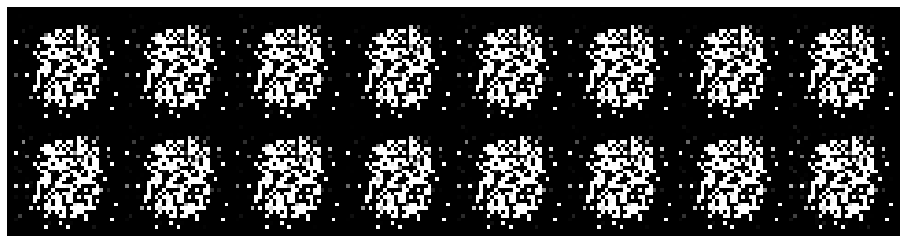

Epoch: 3, Batch Num: [500/600]


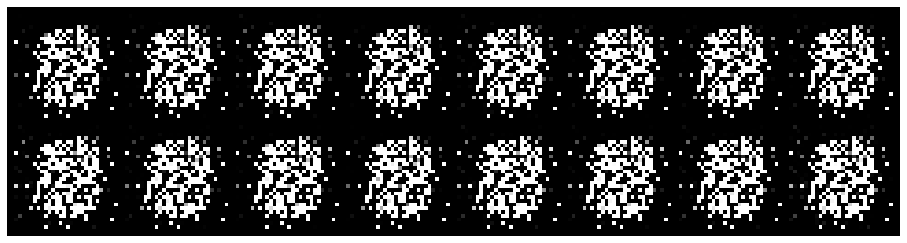

Epoch: 4, Batch Num: [0/600]


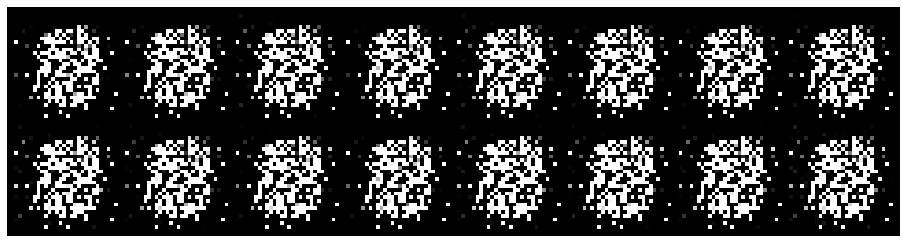

Epoch: 4, Batch Num: [100/600]


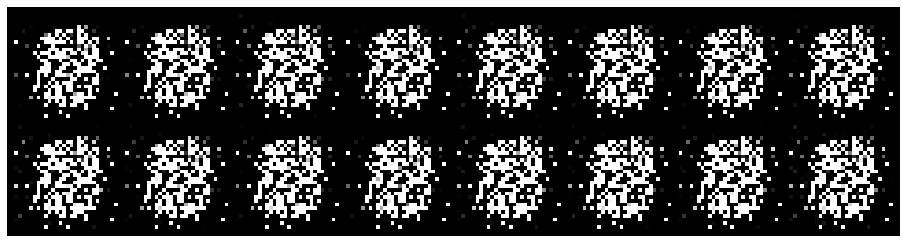

Epoch: 4, Batch Num: [200/600]


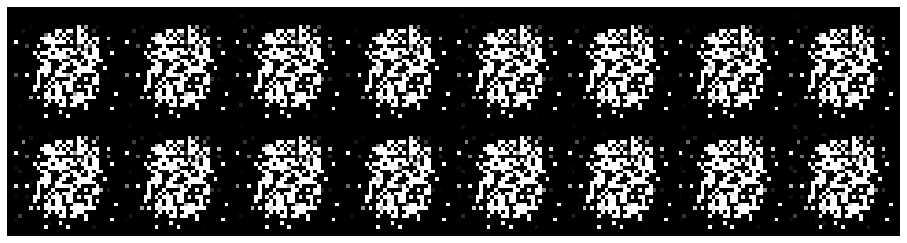

Epoch: 4, Batch Num: [300/600]


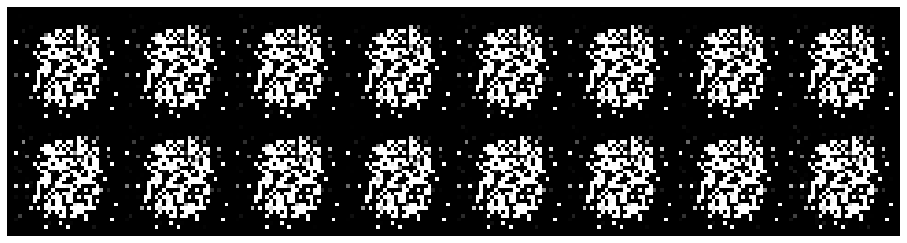

Epoch: 4, Batch Num: [400/600]


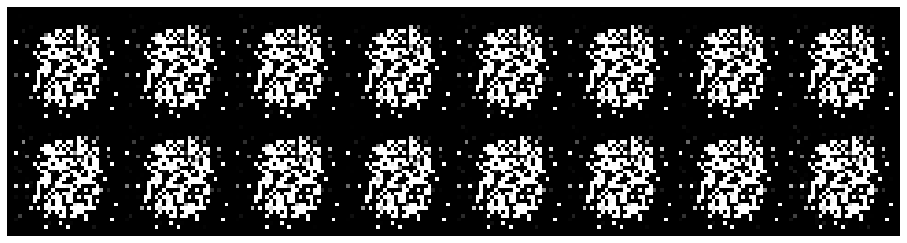

Epoch: 4, Batch Num: [500/600]


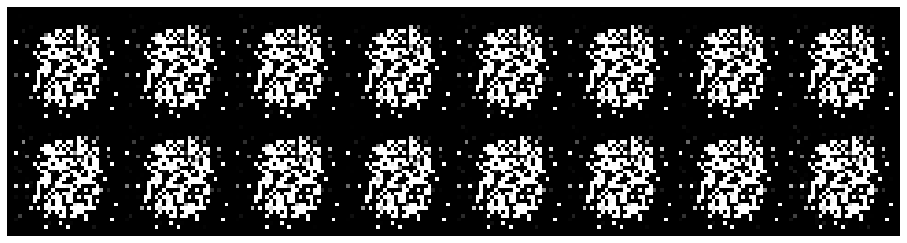

Epoch: 5, Batch Num: [0/600]


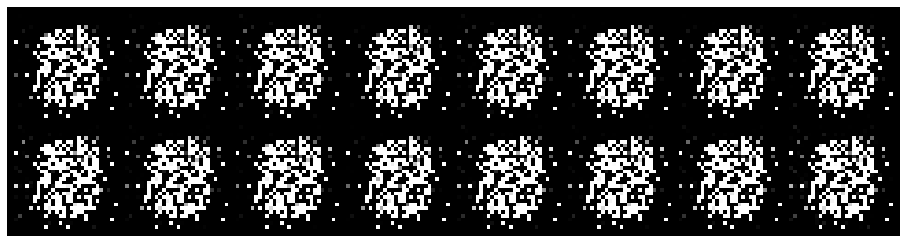

Epoch: 5, Batch Num: [100/600]


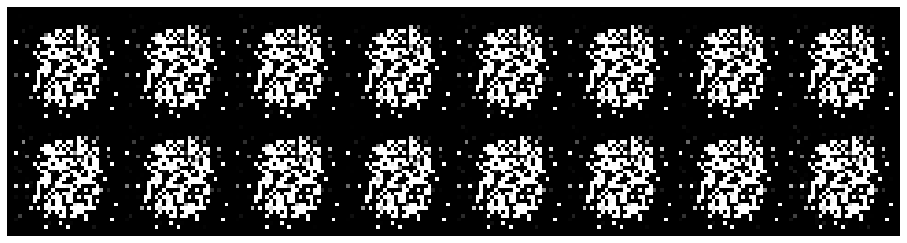

Epoch: 5, Batch Num: [200/600]


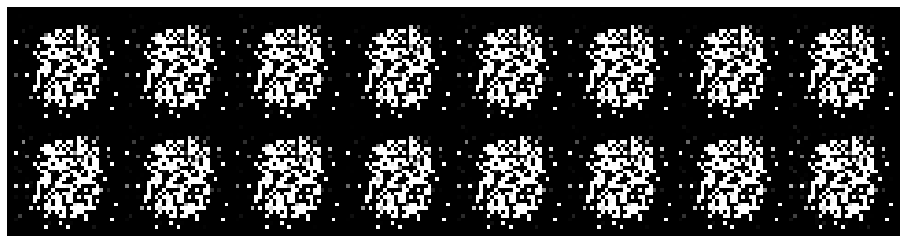

Epoch: 5, Batch Num: [300/600]


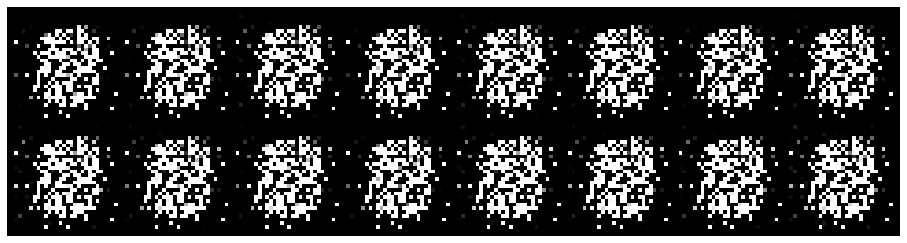

Epoch: 5, Batch Num: [400/600]


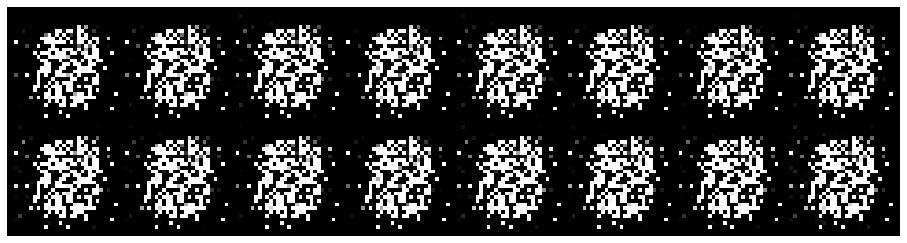

Epoch: 5, Batch Num: [500/600]


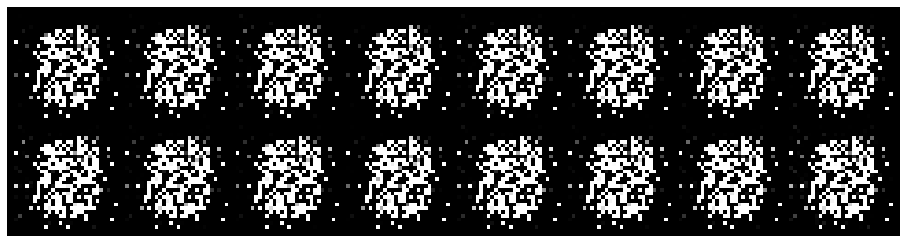

Epoch: 6, Batch Num: [0/600]


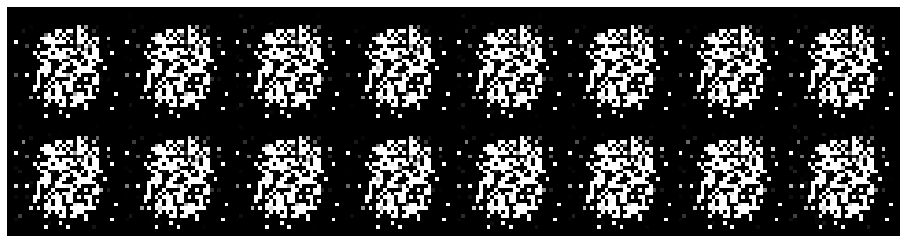

Epoch: 6, Batch Num: [100/600]


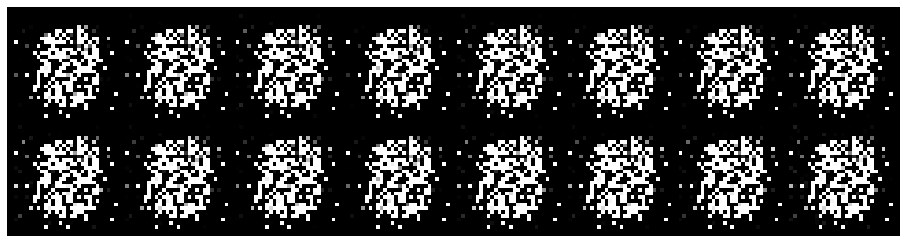

Epoch: 6, Batch Num: [200/600]


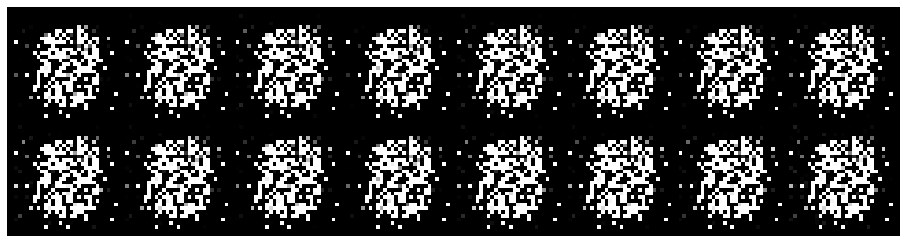

Epoch: 6, Batch Num: [300/600]


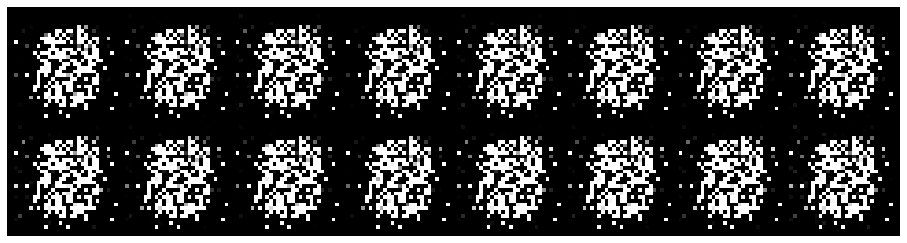

Epoch: 6, Batch Num: [400/600]


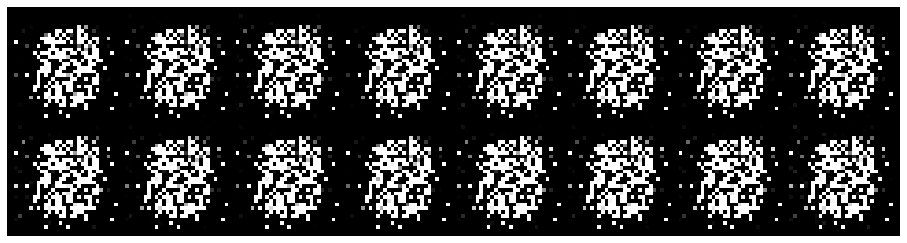

Epoch: 6, Batch Num: [500/600]


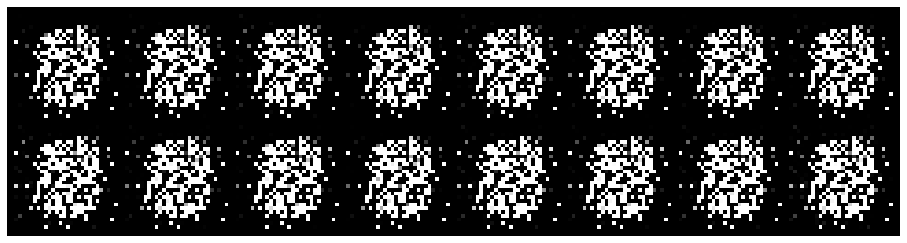

Epoch: 7, Batch Num: [0/600]


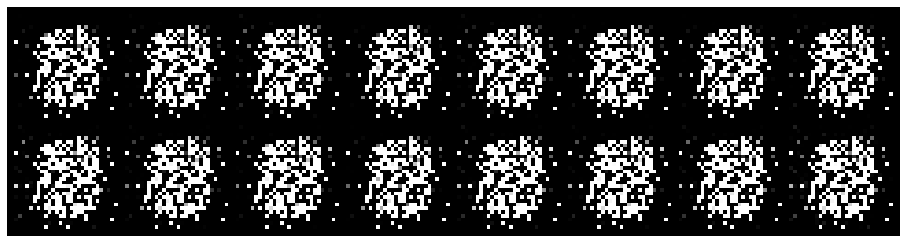

Epoch: 7, Batch Num: [100/600]


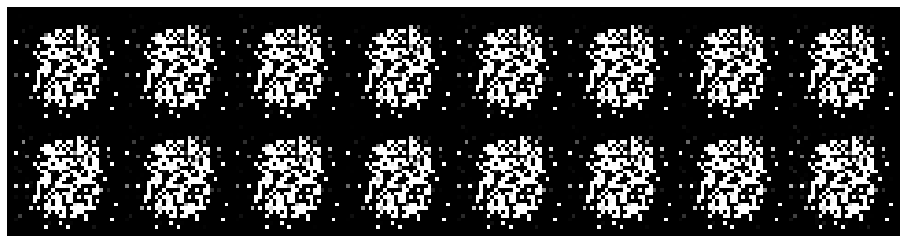

Epoch: 7, Batch Num: [200/600]


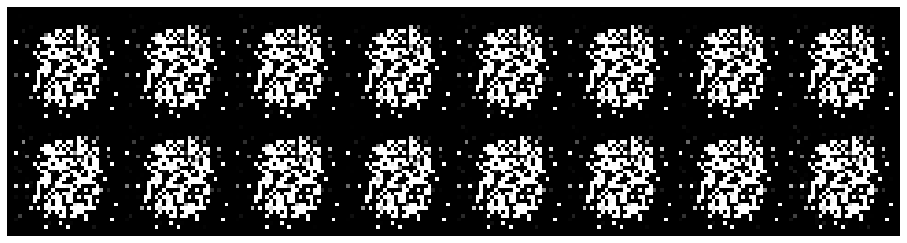

Epoch: 7, Batch Num: [300/600]


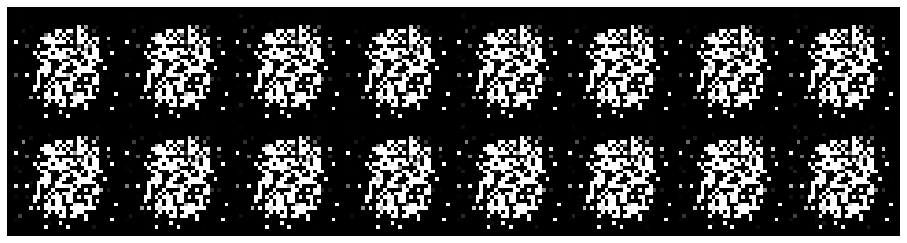

Epoch: 7, Batch Num: [400/600]


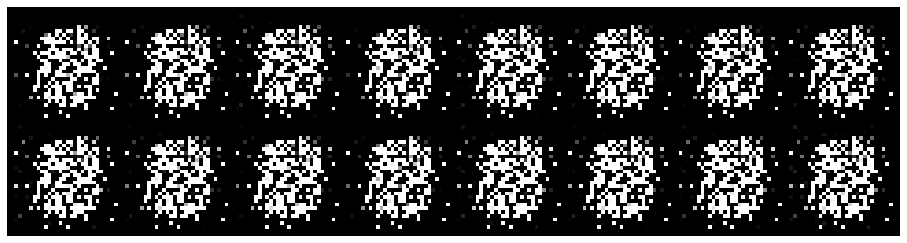

Epoch: 7, Batch Num: [500/600]


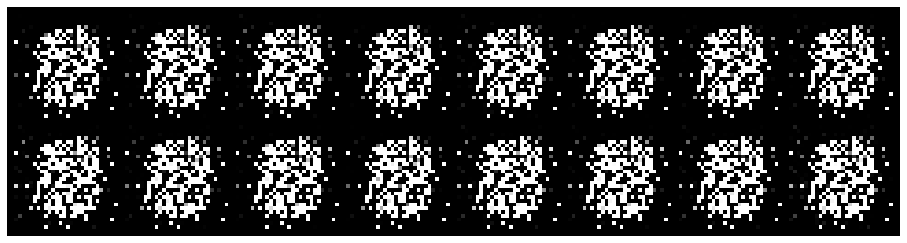

Epoch: 8, Batch Num: [0/600]


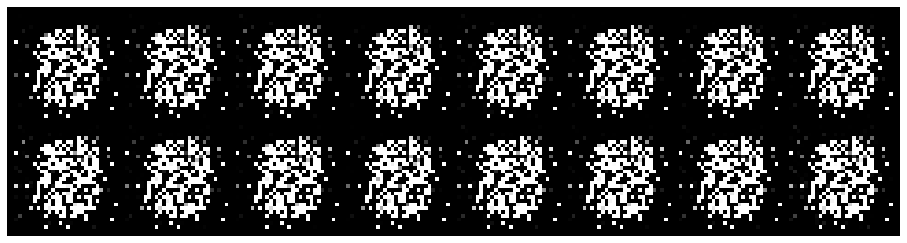

Epoch: 8, Batch Num: [100/600]


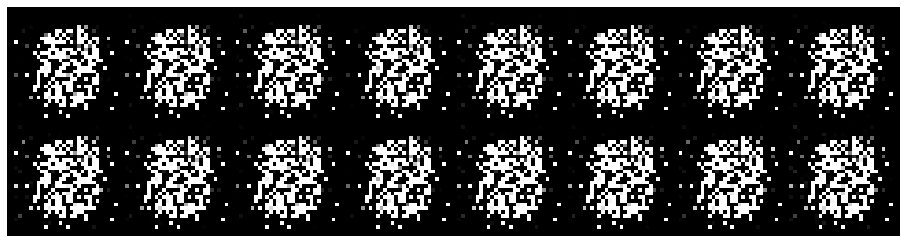

Epoch: 8, Batch Num: [200/600]


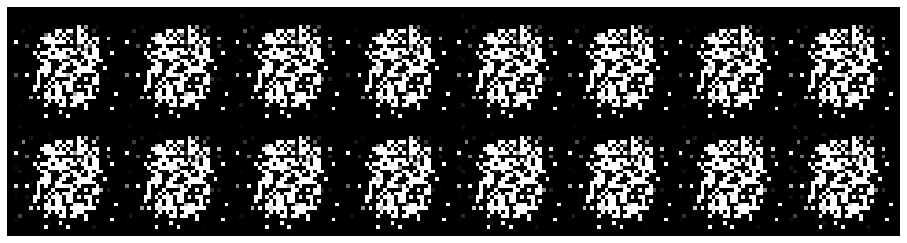

Epoch: 8, Batch Num: [300/600]


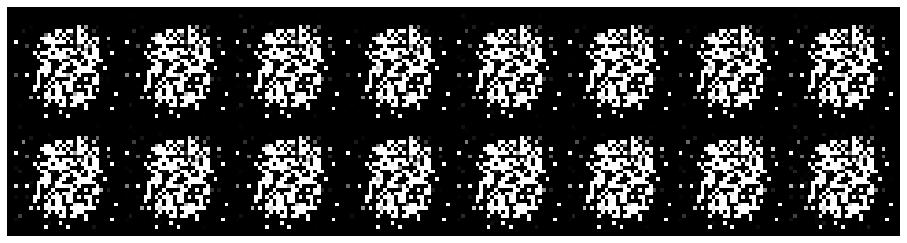

Epoch: 8, Batch Num: [400/600]


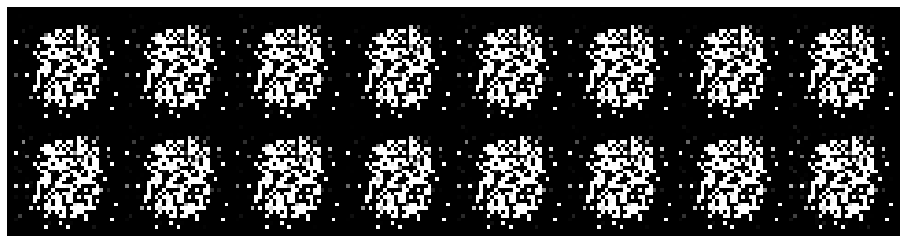

Epoch: 8, Batch Num: [500/600]


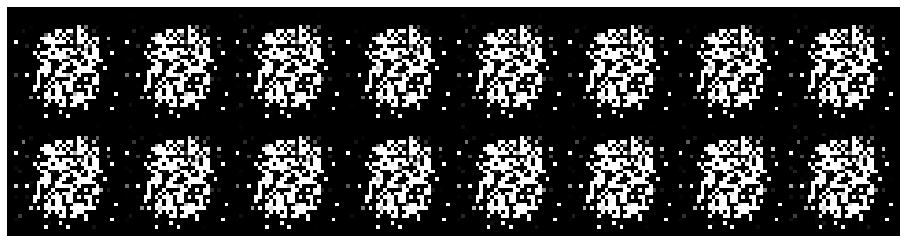

Epoch: 9, Batch Num: [0/600]


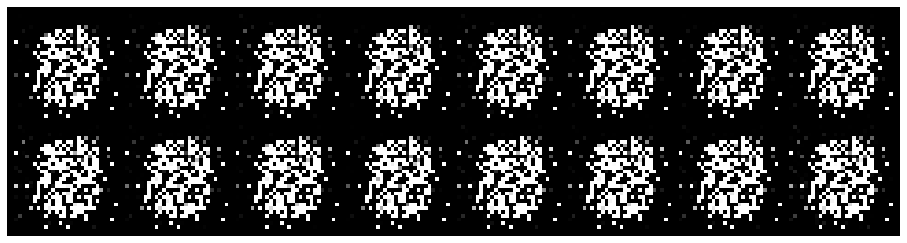

Epoch: 9, Batch Num: [100/600]


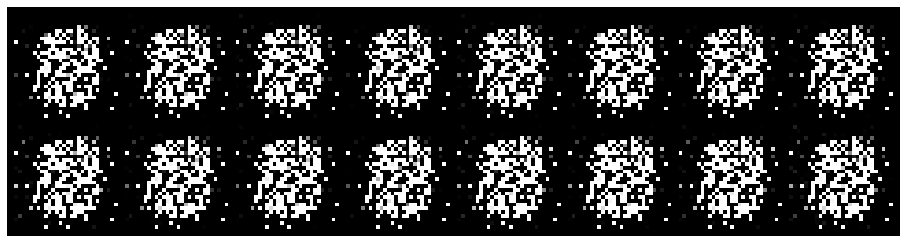

Epoch: 9, Batch Num: [200/600]


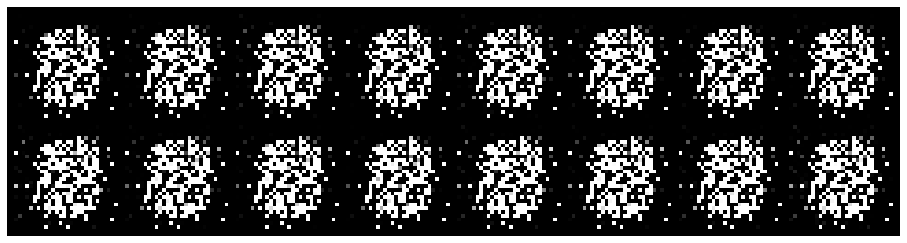

Epoch: 9, Batch Num: [300/600]


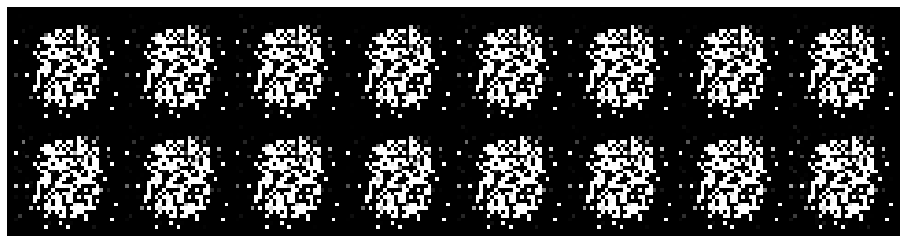

Epoch: 9, Batch Num: [400/600]


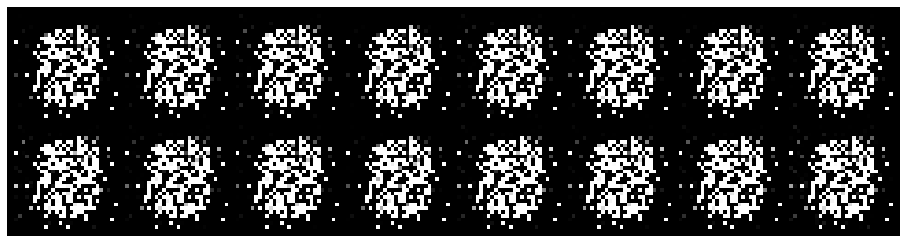

Epoch: 9, Batch Num: [500/600]


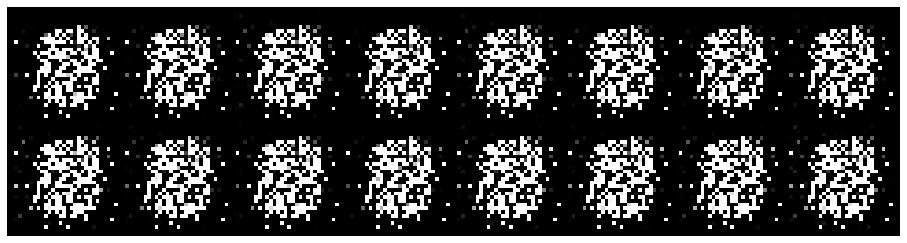

Epoch: 10, Batch Num: [0/600]


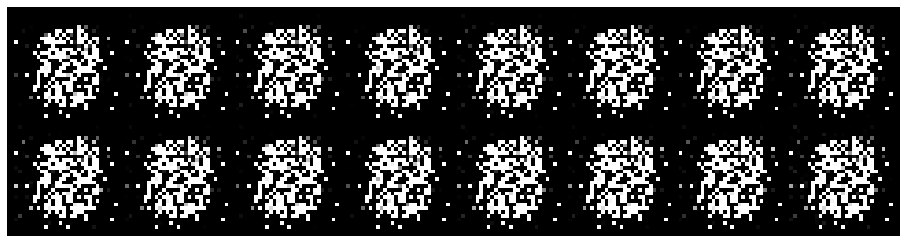

Epoch: 10, Batch Num: [100/600]


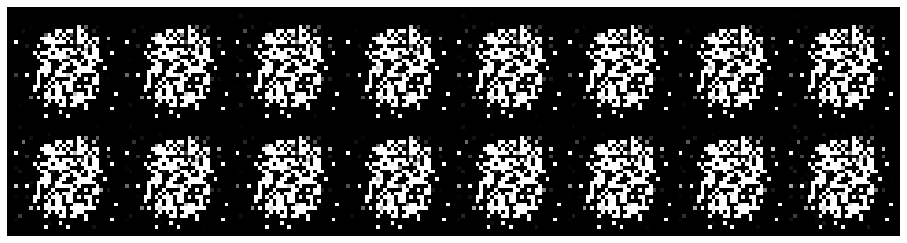

Epoch: 10, Batch Num: [200/600]


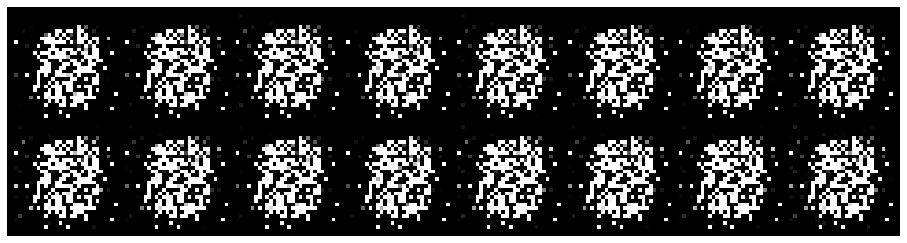

Epoch: 10, Batch Num: [300/600]


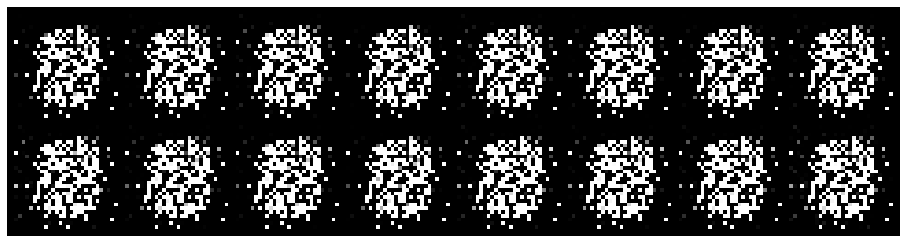

Epoch: 10, Batch Num: [400/600]


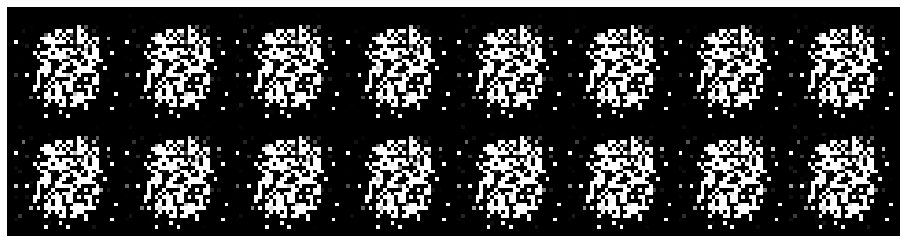

Epoch: 10, Batch Num: [500/600]


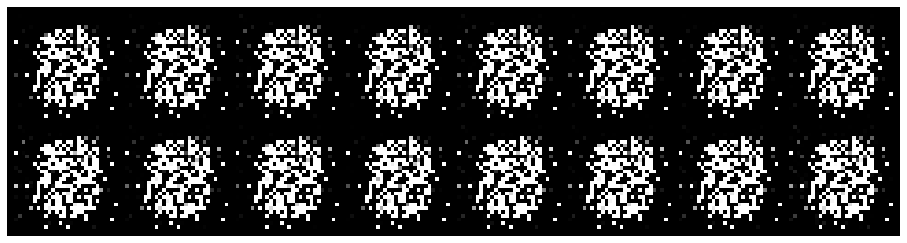

Epoch: 11, Batch Num: [0/600]


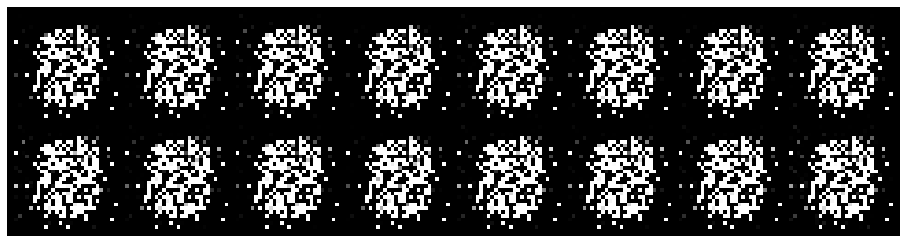

Epoch: 11, Batch Num: [100/600]


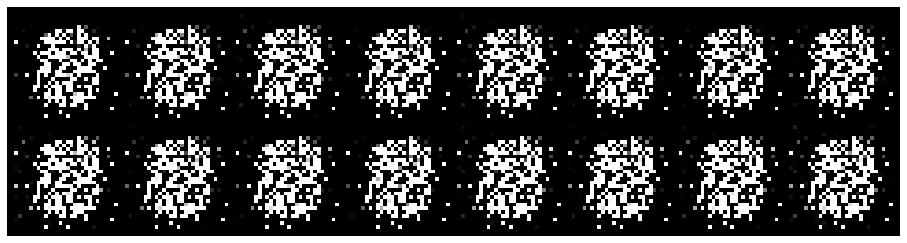

Epoch: 11, Batch Num: [200/600]


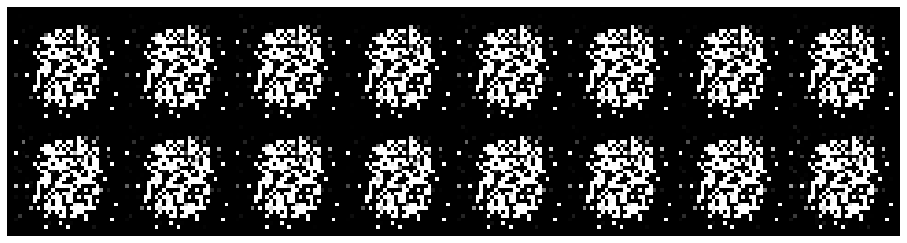

Epoch: 11, Batch Num: [300/600]


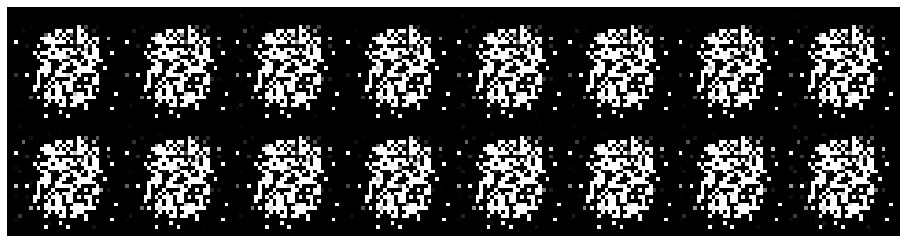

Epoch: 11, Batch Num: [400/600]


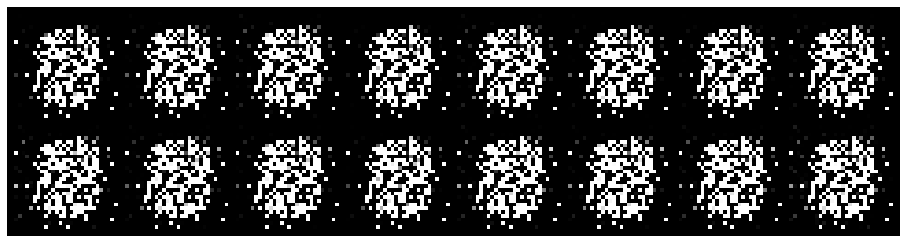

Epoch: 11, Batch Num: [500/600]


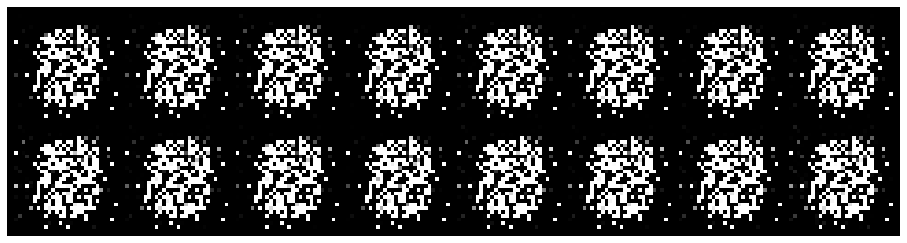

Epoch: 12, Batch Num: [0/600]


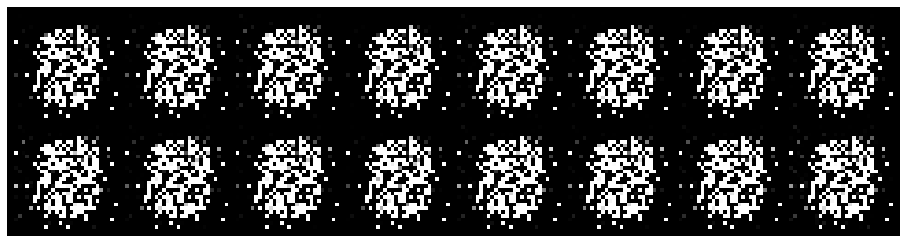

Epoch: 12, Batch Num: [100/600]


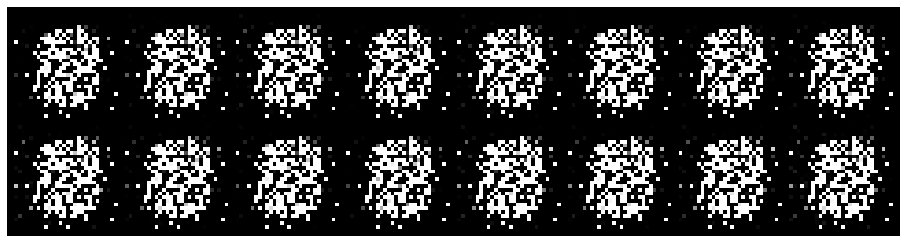

Epoch: 12, Batch Num: [200/600]


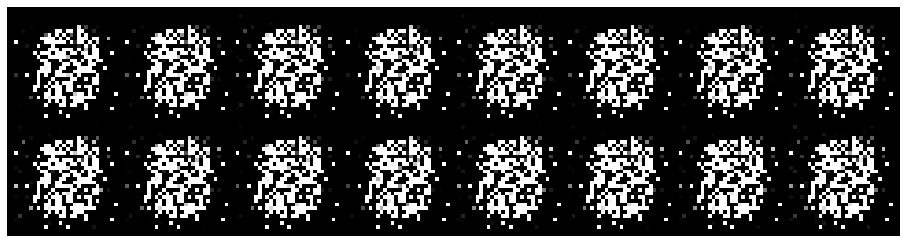

Epoch: 12, Batch Num: [300/600]


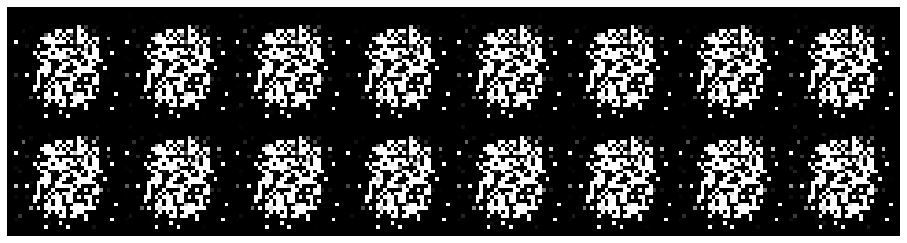

Epoch: 12, Batch Num: [400/600]


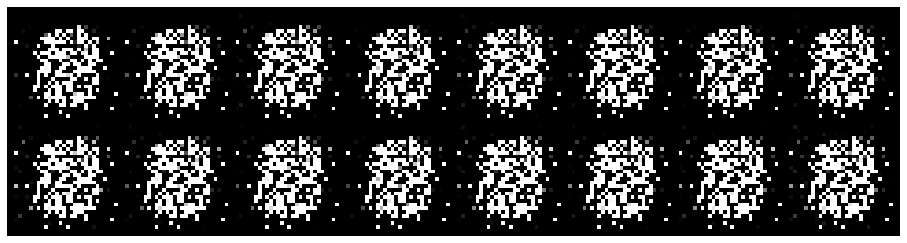

Epoch: 12, Batch Num: [500/600]


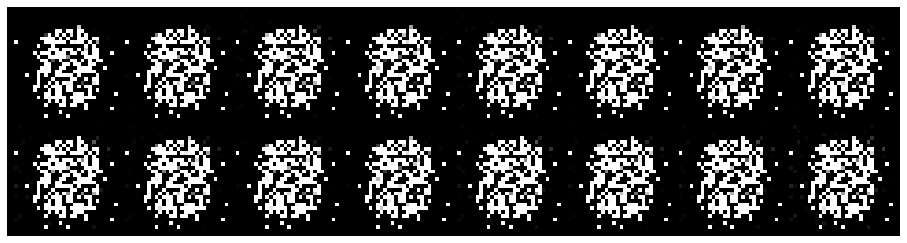

Epoch: 13, Batch Num: [0/600]


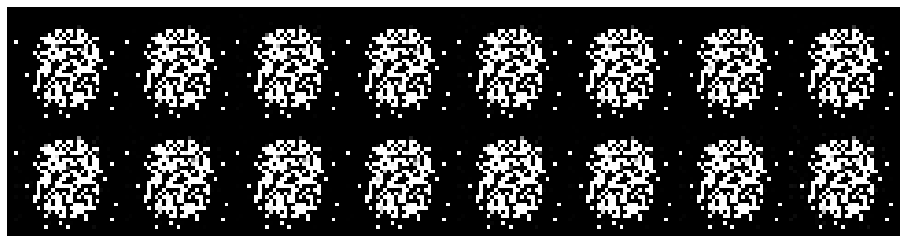

Epoch: 13, Batch Num: [100/600]


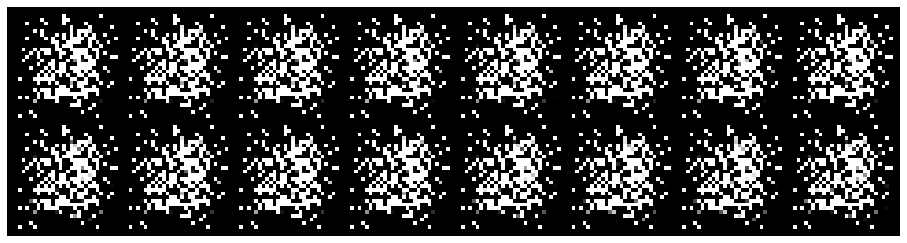

Epoch: 13, Batch Num: [200/600]


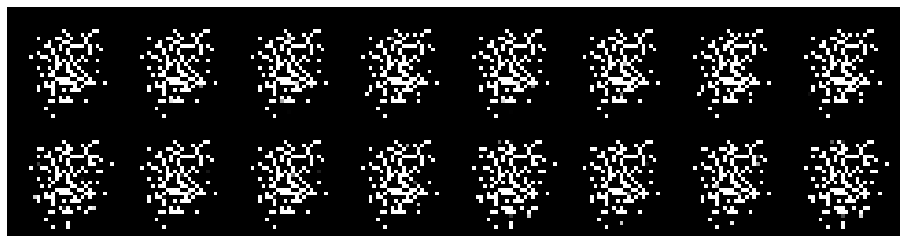

Epoch: 13, Batch Num: [300/600]


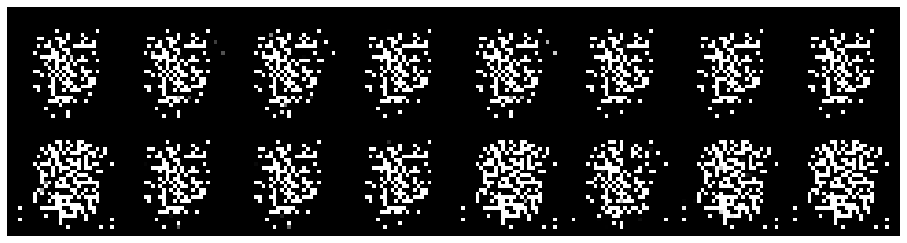

Epoch: 13, Batch Num: [400/600]


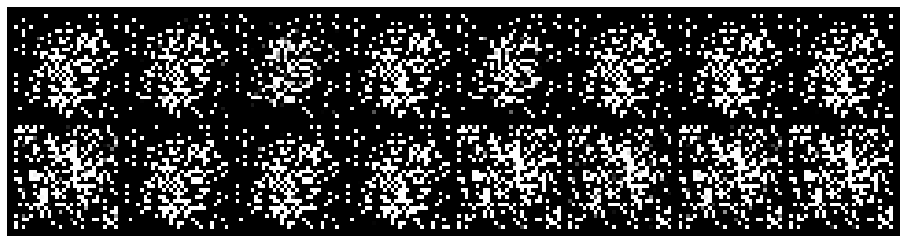

Epoch: 13, Batch Num: [500/600]


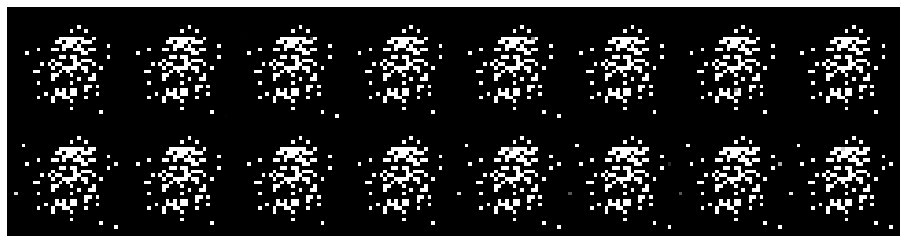

Epoch: 14, Batch Num: [0/600]


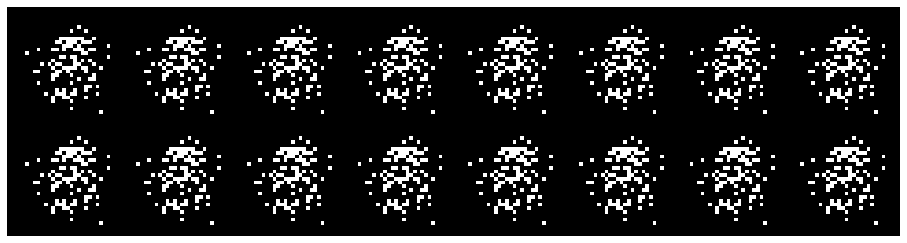

Epoch: 14, Batch Num: [100/600]


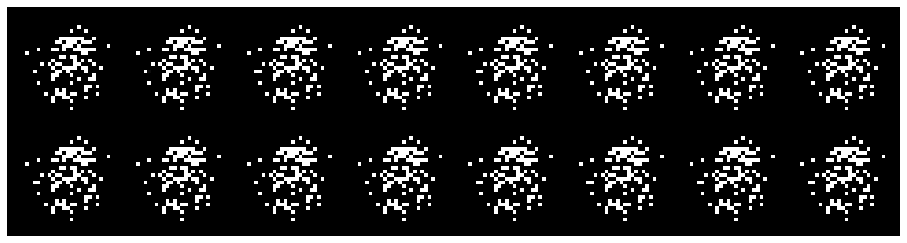

Epoch: 14, Batch Num: [200/600]


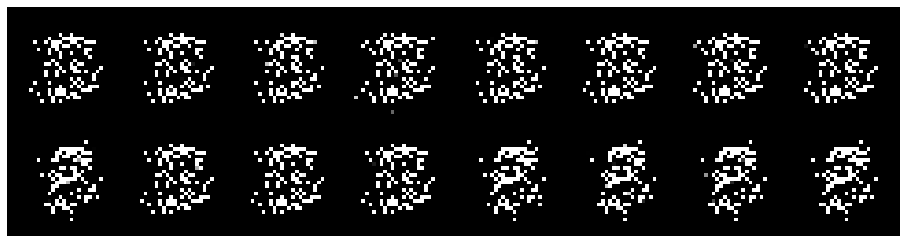

Epoch: 14, Batch Num: [300/600]


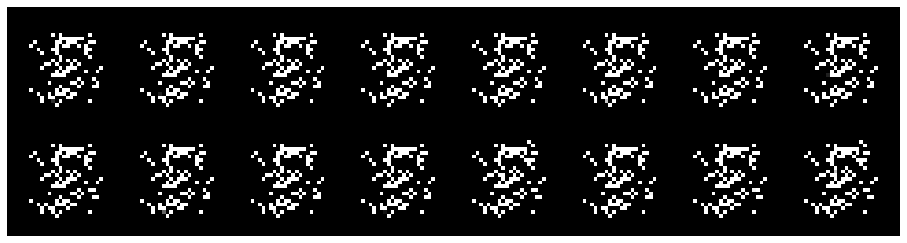

Epoch: 14, Batch Num: [400/600]


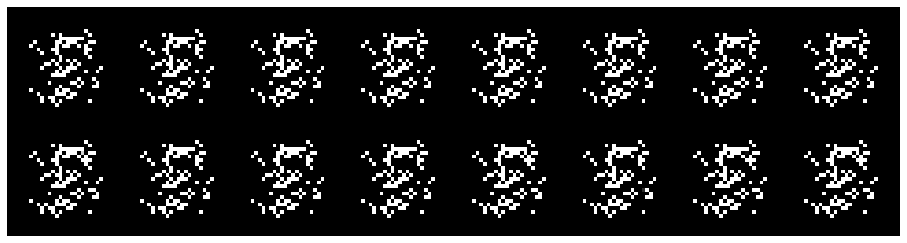

Epoch: 14, Batch Num: [500/600]


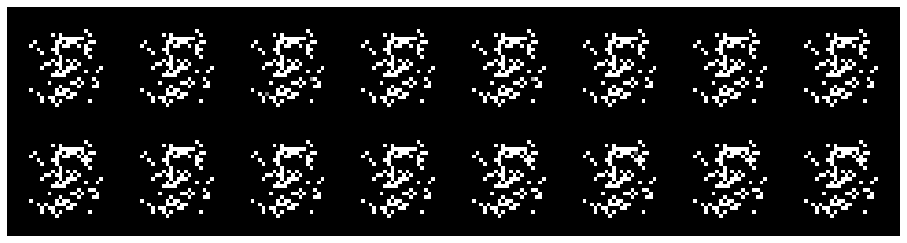

Epoch: 15, Batch Num: [0/600]


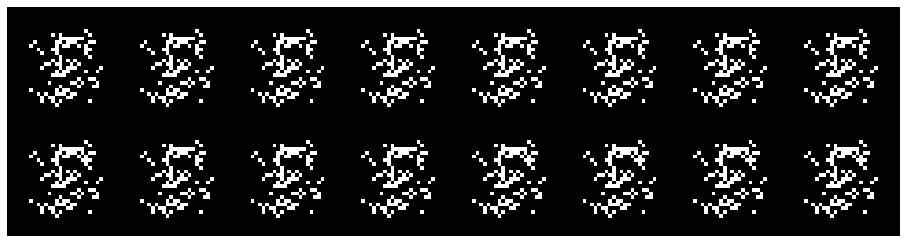

Epoch: 15, Batch Num: [100/600]


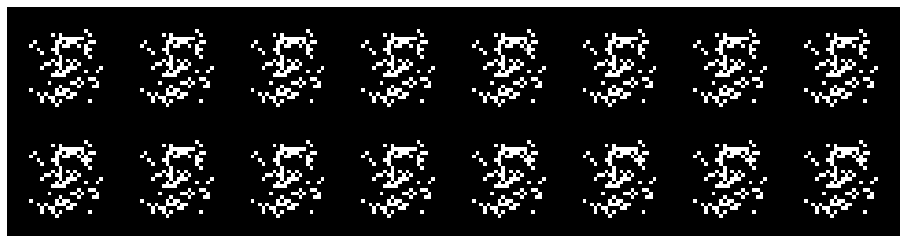

Epoch: 15, Batch Num: [200/600]


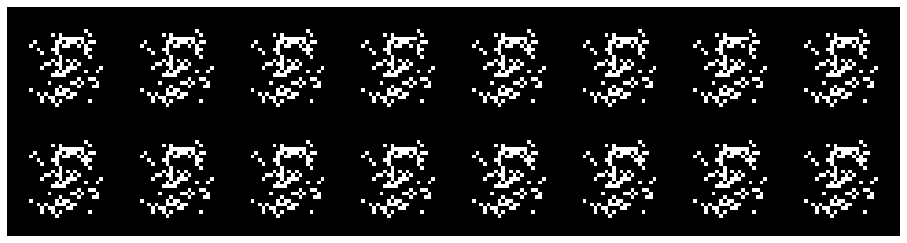

Epoch: 15, Batch Num: [300/600]


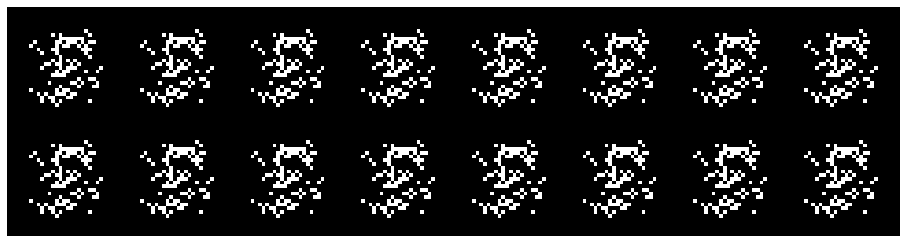

Epoch: 15, Batch Num: [400/600]


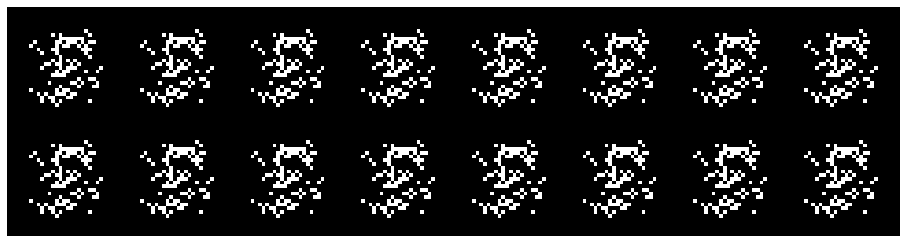

Epoch: 15, Batch Num: [500/600]


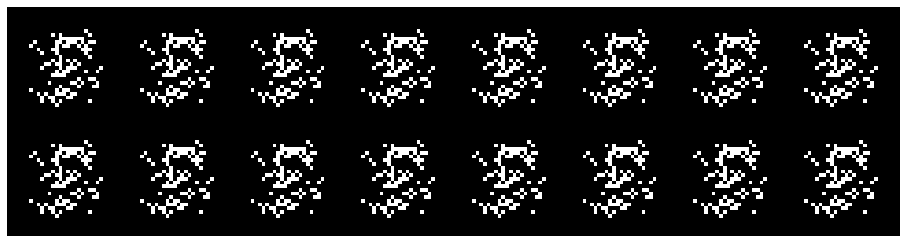

Epoch: 16, Batch Num: [0/600]


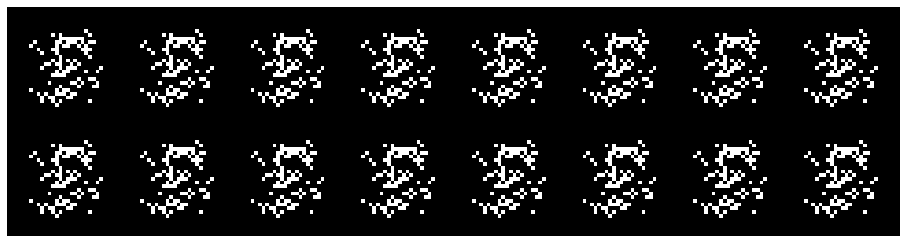

Epoch: 16, Batch Num: [100/600]


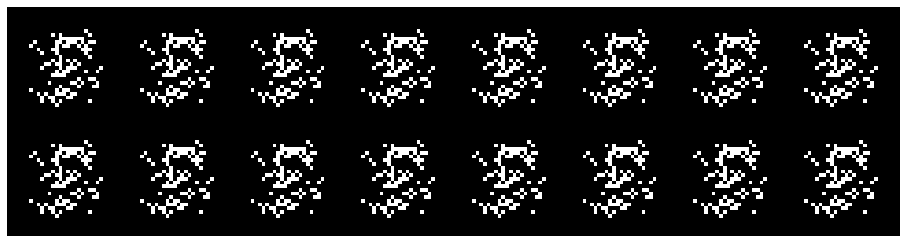

Epoch: 16, Batch Num: [200/600]


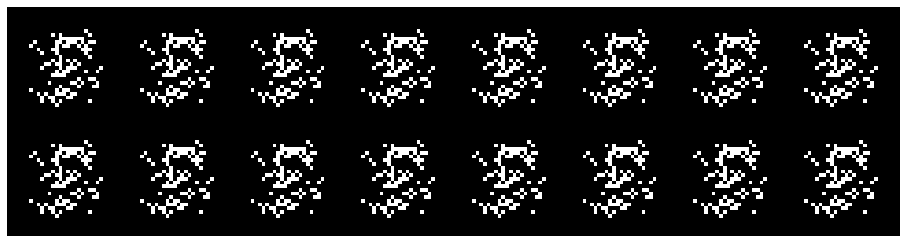

Epoch: 16, Batch Num: [300/600]


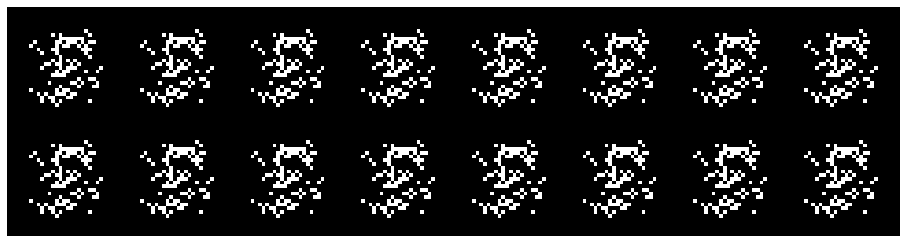

Epoch: 16, Batch Num: [400/600]


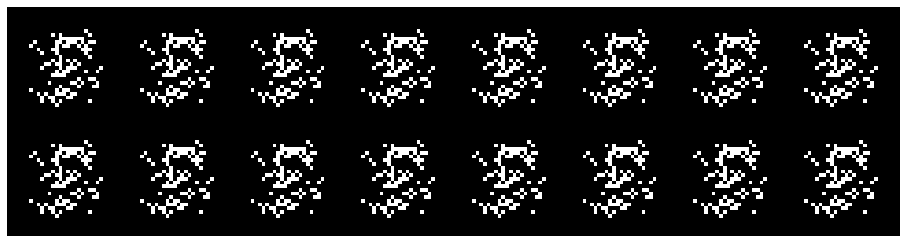

Epoch: 16, Batch Num: [500/600]


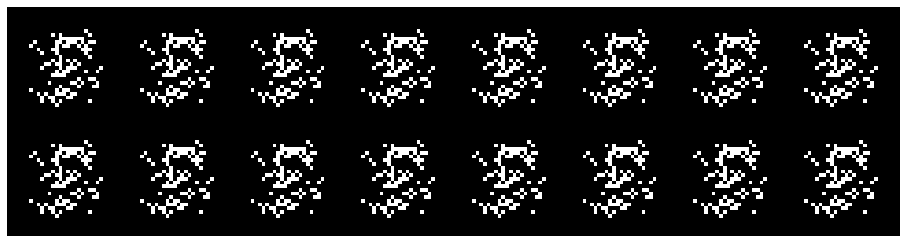

Epoch: 17, Batch Num: [0/600]


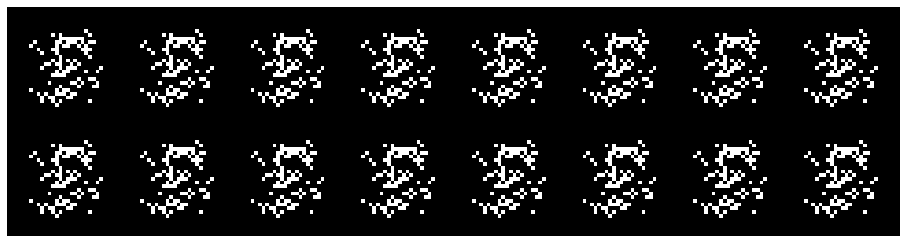

Epoch: 17, Batch Num: [100/600]


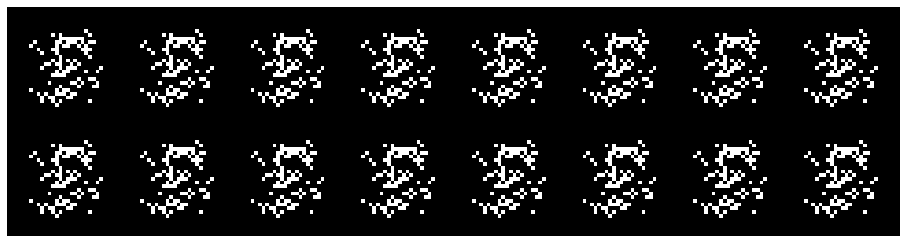

Epoch: 17, Batch Num: [200/600]


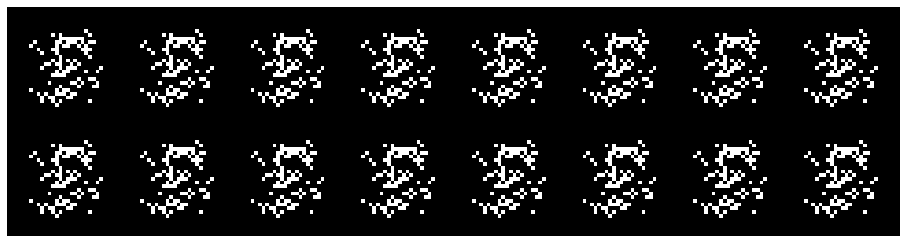

Epoch: 17, Batch Num: [300/600]


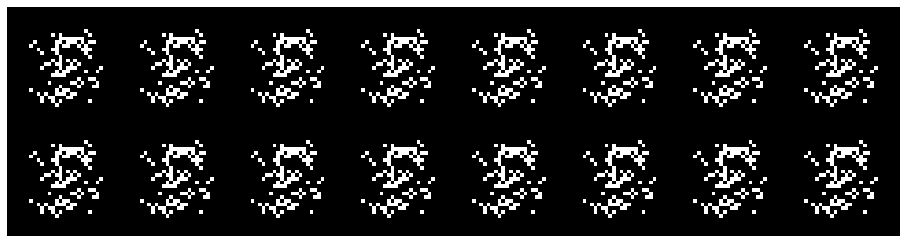

Epoch: 17, Batch Num: [400/600]


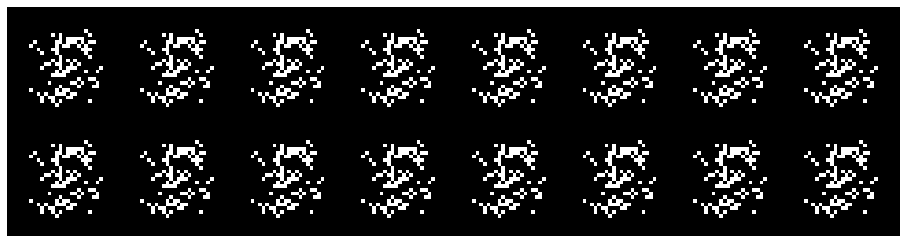

Epoch: 17, Batch Num: [500/600]


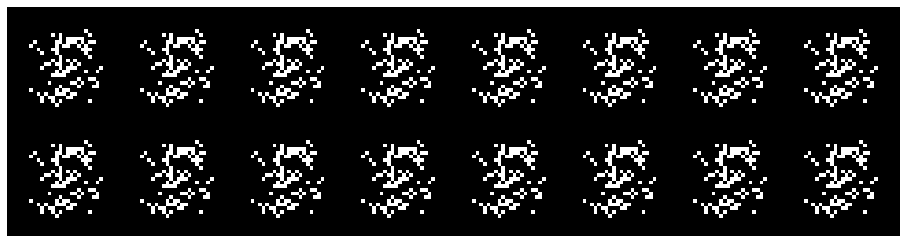

Epoch: 18, Batch Num: [0/600]


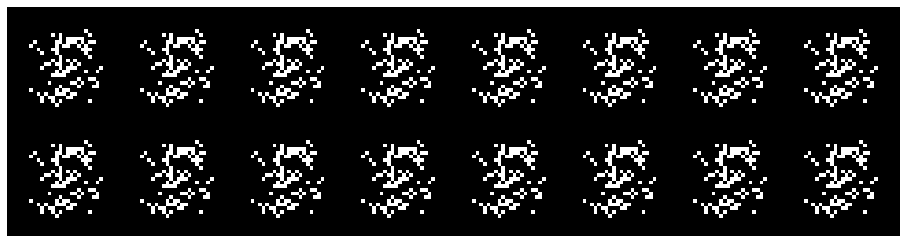

Epoch: 18, Batch Num: [100/600]


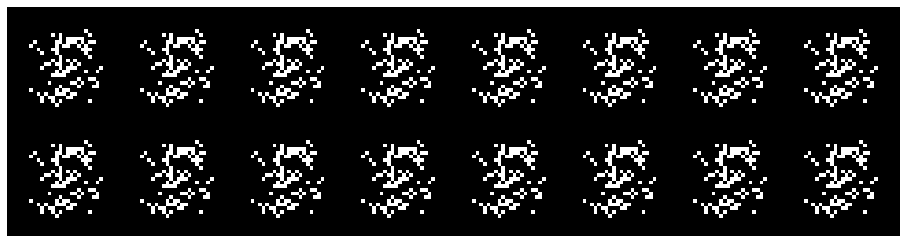

Epoch: 18, Batch Num: [200/600]


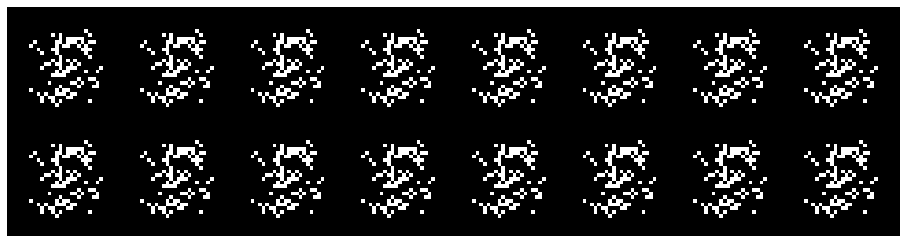

Epoch: 18, Batch Num: [300/600]


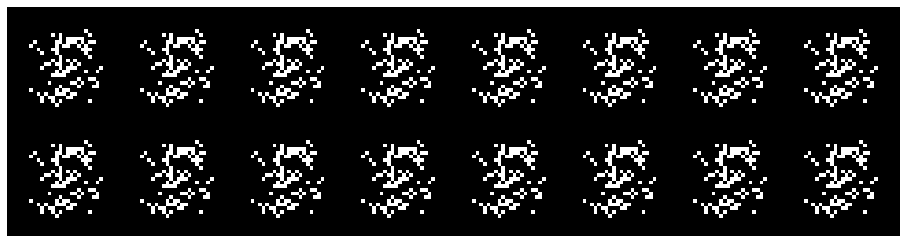

Epoch: 18, Batch Num: [400/600]


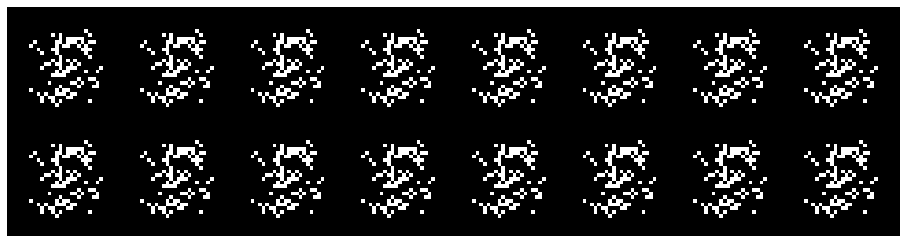

Epoch: 18, Batch Num: [500/600]


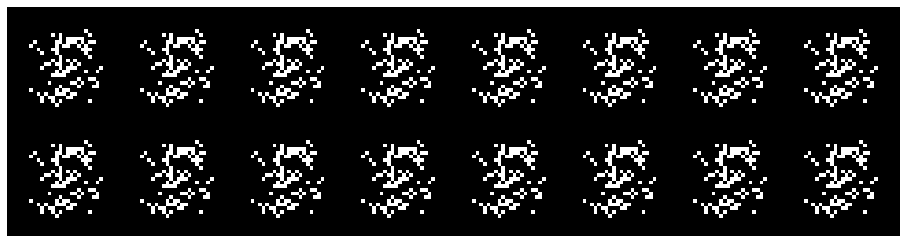

Epoch: 19, Batch Num: [0/600]


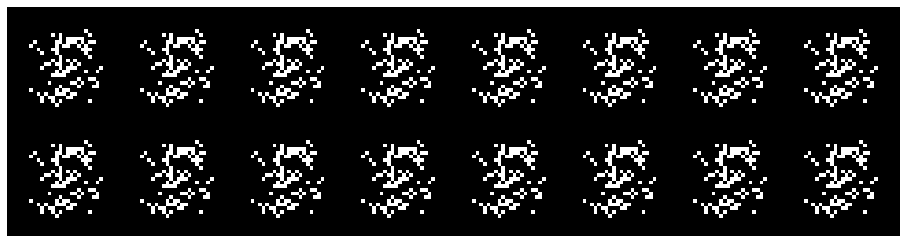

Epoch: 19, Batch Num: [100/600]


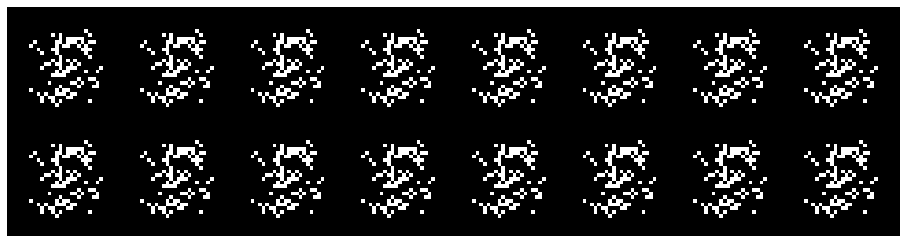

Epoch: 19, Batch Num: [200/600]


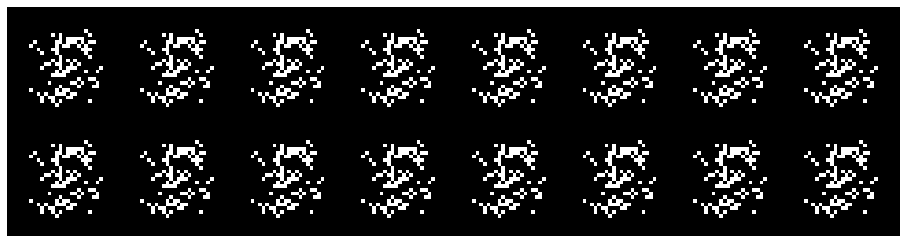

Epoch: 19, Batch Num: [300/600]


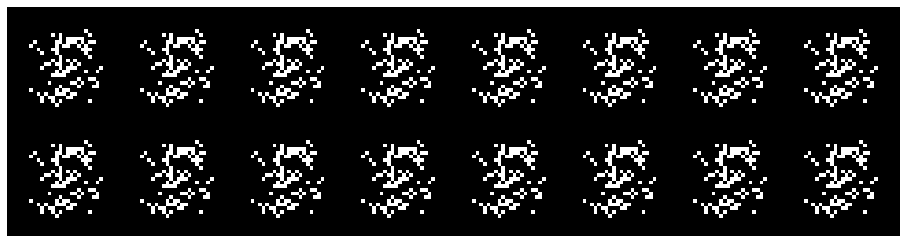

Epoch: 19, Batch Num: [400/600]


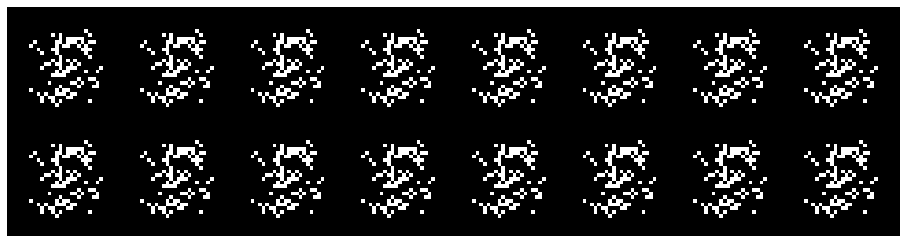

Epoch: 19, Batch Num: [500/600]


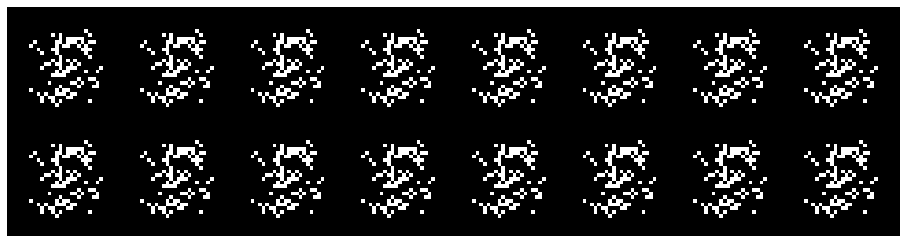

In [19]:
for epoch in range(20):
    for n_batch, (real_batch,_) in enumerate(data_loader):

        # 1 Train Discriminator
        # 1.1 Prepare real data
        real_data = Variable(gt.images_to_vectors(real_batch))
        if torch.cuda.is_available(): real_data = real_data.cuda()
            
        # 1.2 Generate fake data with the Generator
        """ A COMPLETER : Créer des vecteurs bruit """
        noise = gt.noise(100)

        """ A COMPLETER : Générer des images avec le générateur """
        fake_data = generator(noise)
        
        # 1.3 Train Discriminator 
        """ A COMPLETER : Entrainer le discriminateur """
        train_discriminator(d_optimizer, real_data, fake_data)
 
        # 2 Train Generator
        # 2.1 Generate noise
        """  A COMPLETER : Créer des vecteurs bruit à nouveau """
        noise = gt.noise(100)
                      
        # 2.2 Train Generator
        """  A COMPLETER : Entrainer le generateur """
        train_generator(g_optimizer, generator(noise))
                              
        # Generate images from a fixed noise input and visualize the output
        gt.plot_gan(epoch, n_batch, num_batches, generator)

###### 7. Exploration et optimisation

Modifiez la structure des deux réseaux (discriminateur et générateur) en ajoutant ou enlevant des couches cachées, en modifiant le nombre de neurones dans ces couches et en jouant sur les paramètres des fonctions LeakyReLU et Dropout.

Après avoir expliqué comment évaluer la qualité des images générées par le générateur, comparez la qualité des résultats obtenus avec les modifications que vous avez testé et essayez d’obtenir le meilleur résultat possible.

In [20]:
class DiscriminatorNet_New(torch.nn.Module):

    def __init__(self):
        super(DiscriminatorNet_New, self).__init__()
        n_features = 784
        n_out = 1
        
        self.hidden0 = nn.Sequential( 
            nn.Linear(n_features, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.5)
        )
      
        self.hidden1 = nn.Sequential( 
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.5)
        )

        #self.hidden2 = nn.Sequential( 
        #    nn.Linear(512, 256),
        #    nn.LeakyReLU(0.2),
        #    nn.Dropout(0.3)
       # )

        
            
        self.out = nn.Sequential(
            torch.nn.Linear(512, n_out),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        #x = self.hidden2(x)
        #x = self.hidden3(x)
        x = self.out(x)
        return x

In [21]:
class GeneratorNet_New(torch.nn.Module):

    def __init__(self):
        super(GeneratorNet_New, self).__init__()
        
        n_features = 100
        n_out = 784
        
        self.hidden0 = nn.Sequential( 
            nn.Linear(n_features, 256),
            nn.LeakyReLU(0.3)
        )
      
        self.hidden1 = nn.Sequential( 
            nn.Linear(256, 512),
            nn.LeakyReLU(0.3)
        )

        self.hidden2 = nn.Sequential( 
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.3)
        )
            
        self.out = nn.Sequential(
            nn.Linear(1024, n_out),
            nn.Tanh()
        )
    
    def forward(self, x):   
      x = self.hidden0(x)
      x = self.hidden1(x)
      x = self.hidden2(x)
      x = self.out(x)
      return x    

In [22]:
discriminator_new = DiscriminatorNet_New()
generator_new = GeneratorNet_New()
if torch.cuda.is_available():
    discriminator_new.cuda()
    generator_new.cuda()
    
# Optimizers
d_optimizer_new = optim.Adam(discriminator_new.parameters(), lr=0.0002)
g_optimizer_new = optim.Adam(generator_new.parameters(), lr=0.0002)

# Loss function
loss = nn.BCELoss()

In [23]:
def train_discriminator_new(optimizer, real_data, fake_data):
    # Reset gradients
    optimizer.zero_grad()
    
    # 1.1 Train on Real Data
    prediction_real = discriminator_new(real_data) # prédiction du modèle sur les vraies données
    # Calculate error and backpropagate
    error_real = loss(prediction_real, gt.real_data_target(real_data.size(0)))
    error_real.backward()  # calcule les gradients, ceci permet de savoir dans quelle direction on va ajuster les poids
                          # Esk les poids vont augmenter ou diminuer

    # 1.2 Train on Fake Data
    prediction_fake = discriminator_new(fake_data) # prédiction  du modèle sur les fausses données
    # Calculate error and backpropagate
    error_fake = loss(prediction_fake, gt.fake_data_target(real_data.size(0)))
    error_fake.backward()  # calcule les gradients, ceci permet de savoir dans quelle direction on va ajuster les poids
                          # Esk les poids vont augmenter ou diminuer
    
    # 1.3 Update weights with gradients
    optimizer.step()
    
    # Return error
    return error_real + error_fake, prediction_real, prediction_fake

In [24]:
def train_generator_new(optimizer, fake_data):
    # 2. Train Generator
    # Reset gradients
    optimizer.zero_grad()
    # Sample noise and generate fake data
    prediction = discriminator_new(fake_data)
    # Calculate error and backpropagate
    error = loss(prediction, gt.real_data_target(prediction.size(0)))
    error.backward()
    # Update weights with gradients
    optimizer.step()
    # Return error
    return error

Epoch: 0, Batch Num: [0/600]


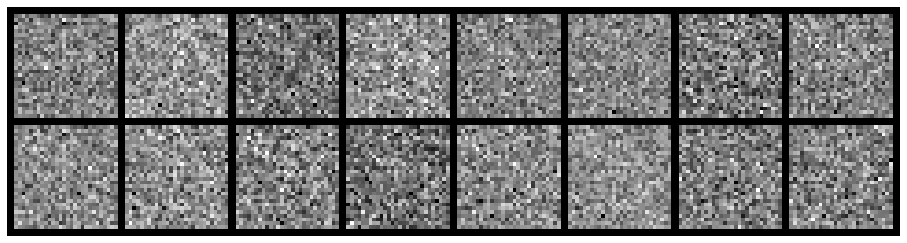

Epoch: 0, Batch Num: [100/600]


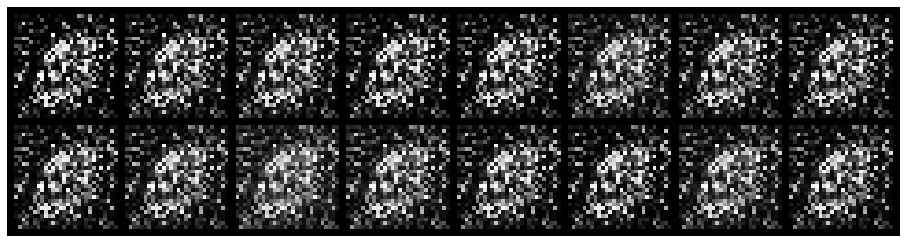

Epoch: 0, Batch Num: [200/600]


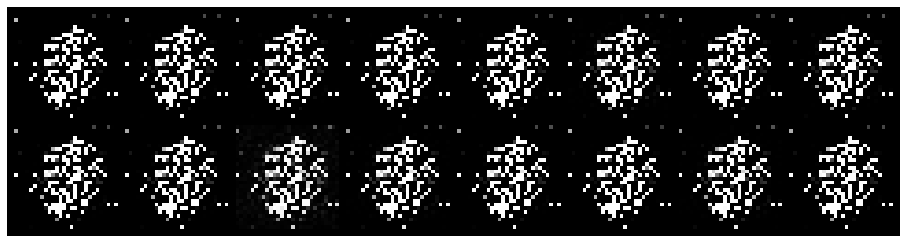

Epoch: 0, Batch Num: [300/600]


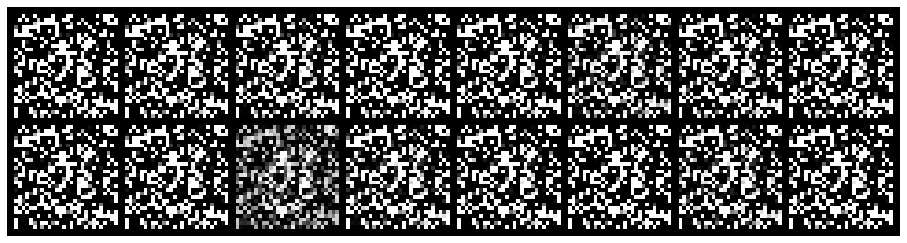

Epoch: 0, Batch Num: [400/600]


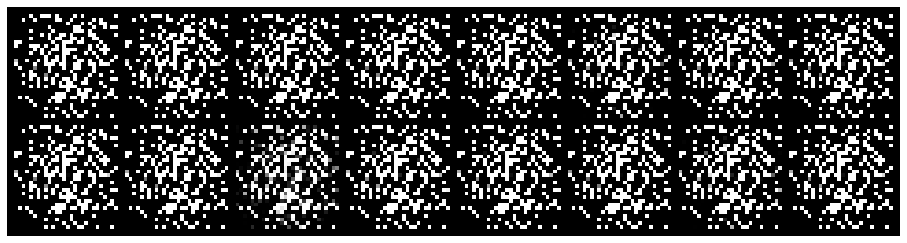

Epoch: 0, Batch Num: [500/600]


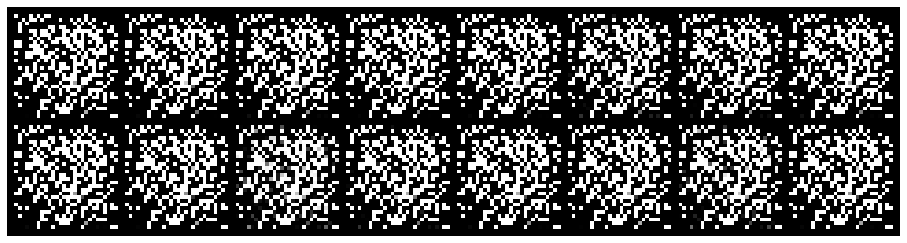

Epoch: 1, Batch Num: [0/600]


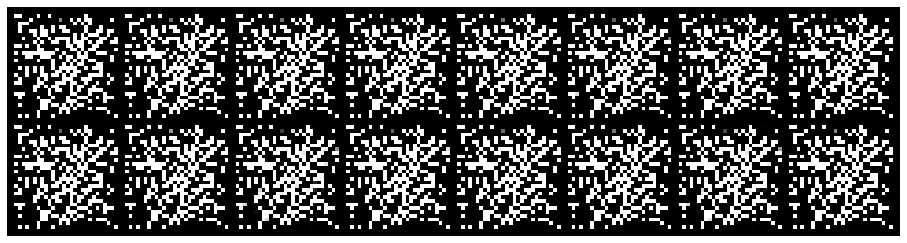

Epoch: 1, Batch Num: [100/600]


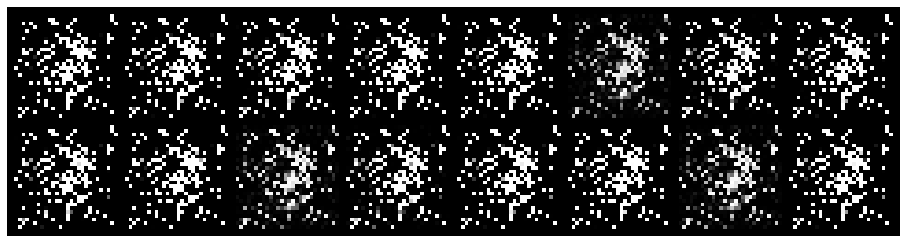

Epoch: 1, Batch Num: [200/600]


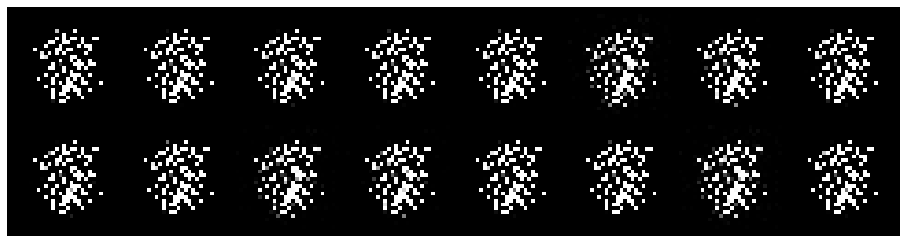

Epoch: 1, Batch Num: [300/600]


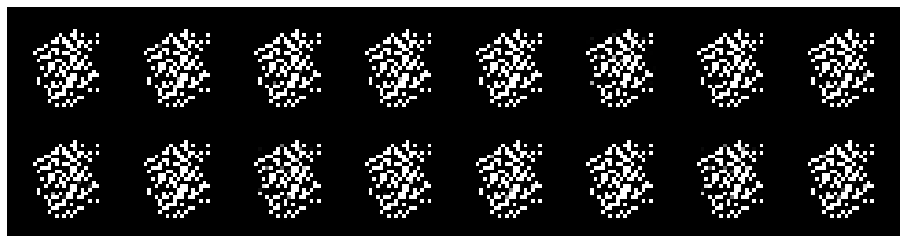

Epoch: 1, Batch Num: [400/600]


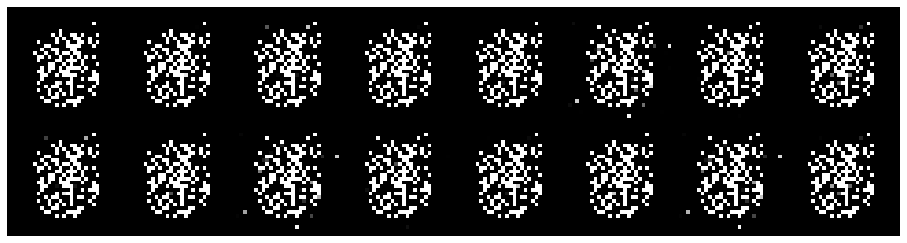

Epoch: 1, Batch Num: [500/600]


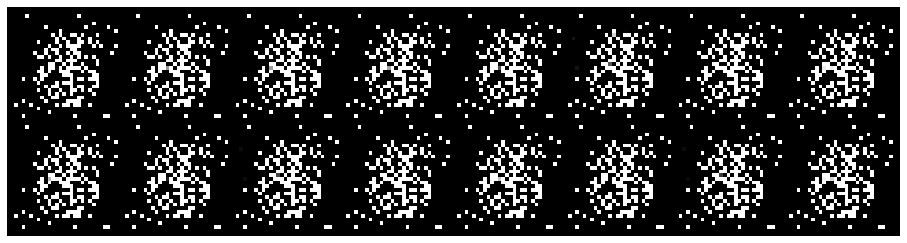

Epoch: 2, Batch Num: [0/600]


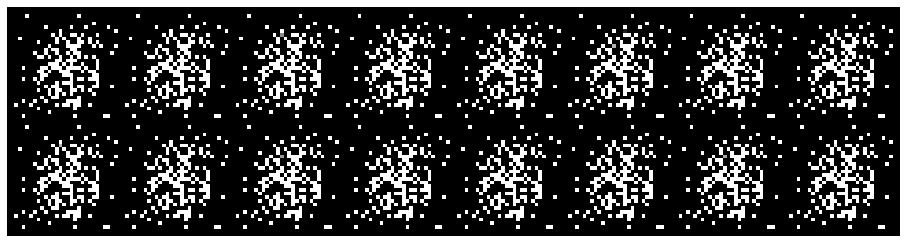

Epoch: 2, Batch Num: [100/600]


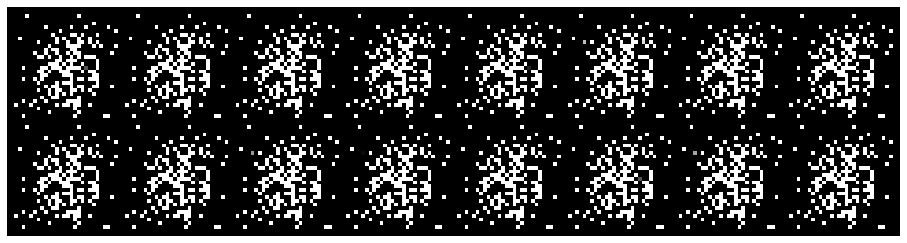

Epoch: 2, Batch Num: [200/600]


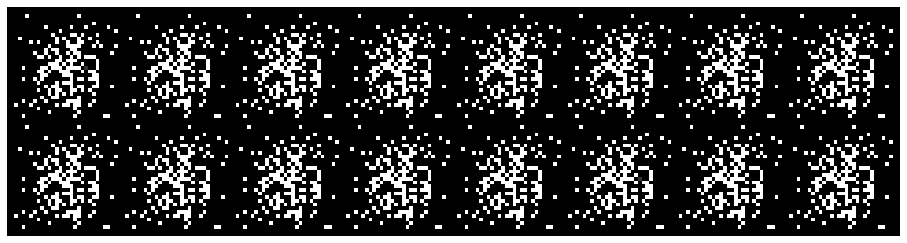

Epoch: 2, Batch Num: [300/600]


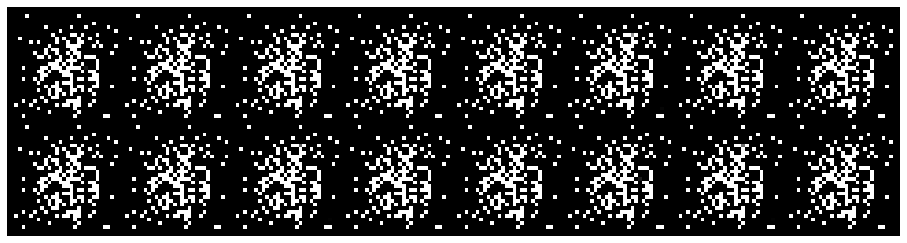

Epoch: 2, Batch Num: [400/600]


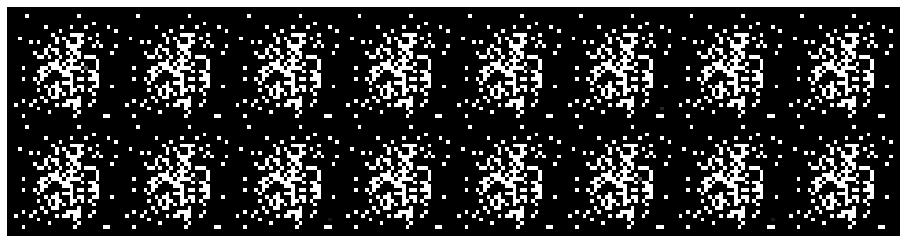

Epoch: 2, Batch Num: [500/600]


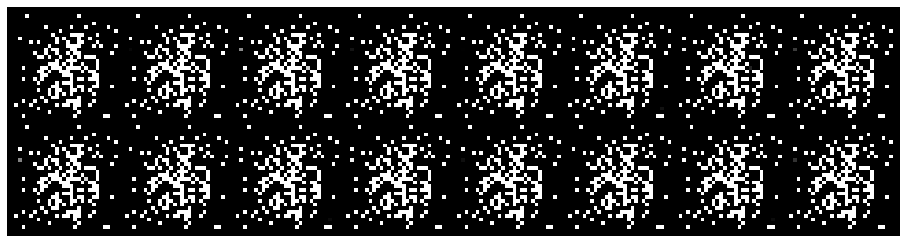

Epoch: 3, Batch Num: [0/600]


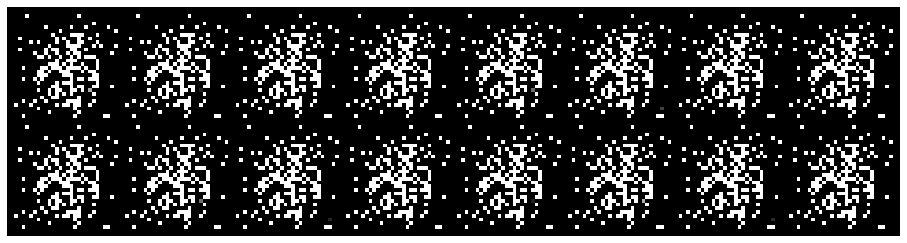

Epoch: 3, Batch Num: [100/600]


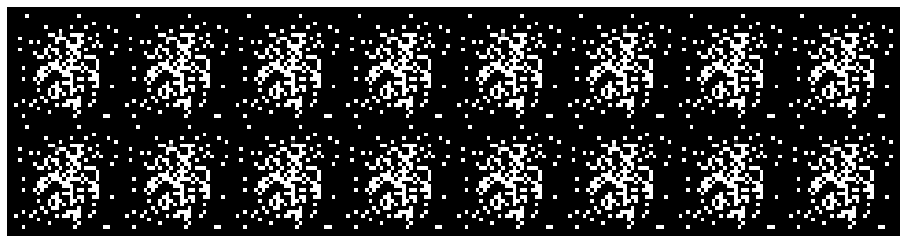

Epoch: 3, Batch Num: [200/600]


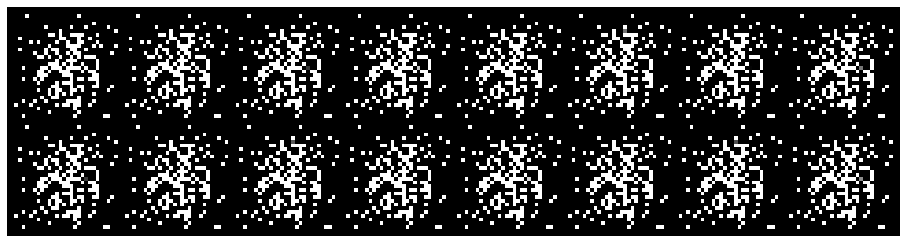

Epoch: 3, Batch Num: [300/600]


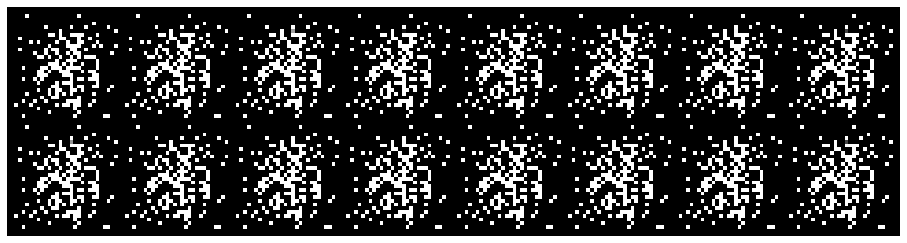

Epoch: 3, Batch Num: [400/600]


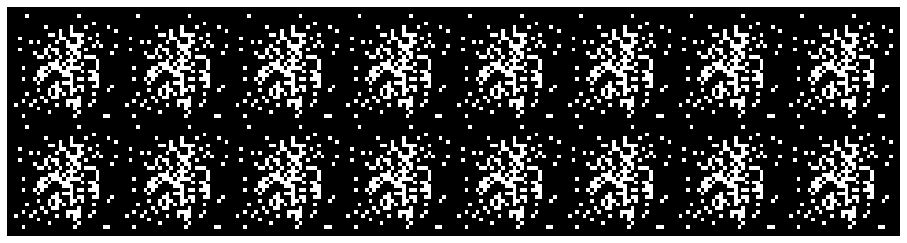

Epoch: 3, Batch Num: [500/600]


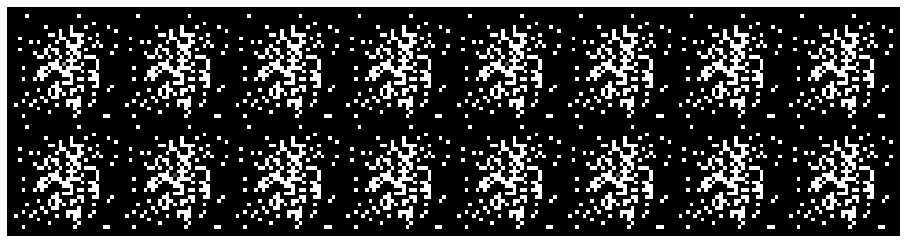

Epoch: 4, Batch Num: [0/600]


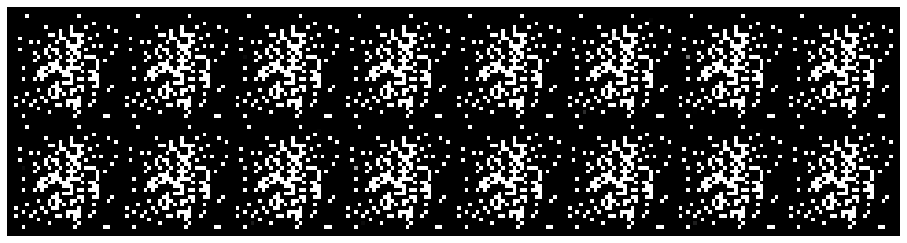

Epoch: 4, Batch Num: [100/600]


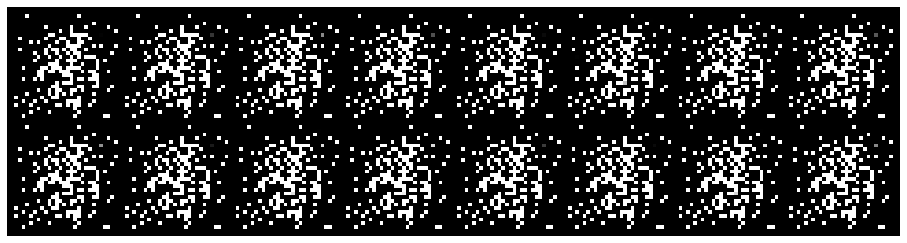

Epoch: 4, Batch Num: [200/600]


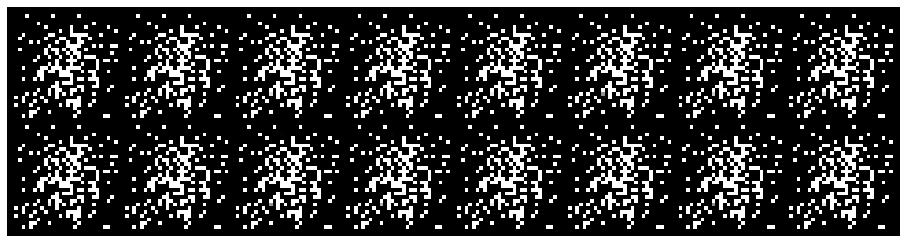

Epoch: 4, Batch Num: [300/600]


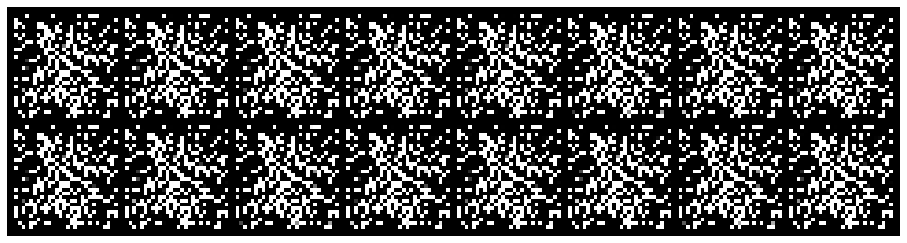

Epoch: 4, Batch Num: [400/600]


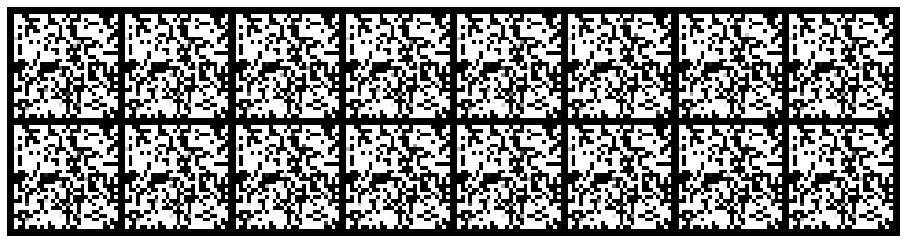

Epoch: 4, Batch Num: [500/600]


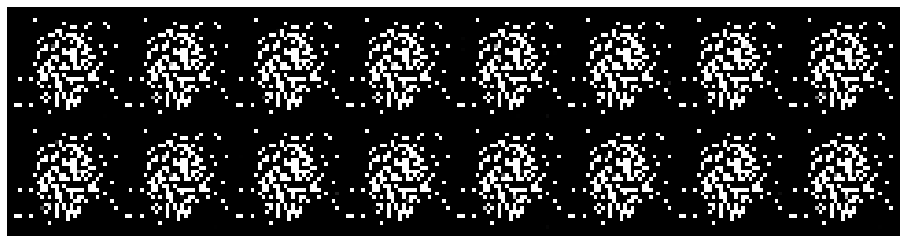

Epoch: 5, Batch Num: [0/600]


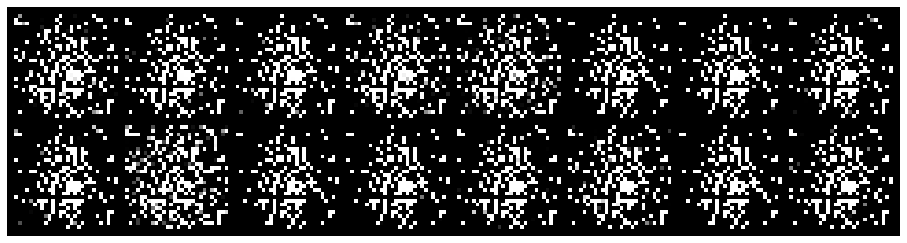

Epoch: 5, Batch Num: [100/600]


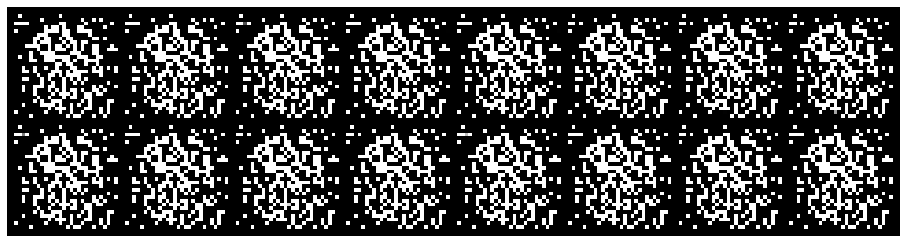

Epoch: 5, Batch Num: [200/600]


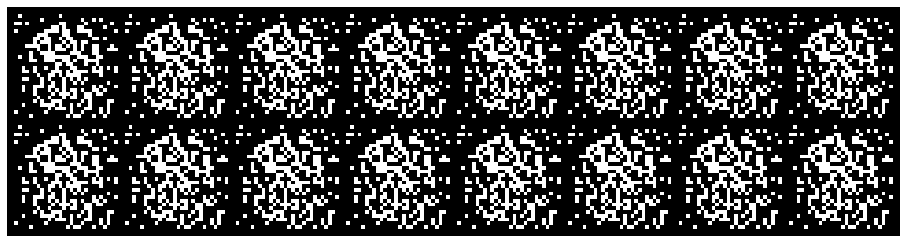

Epoch: 5, Batch Num: [300/600]


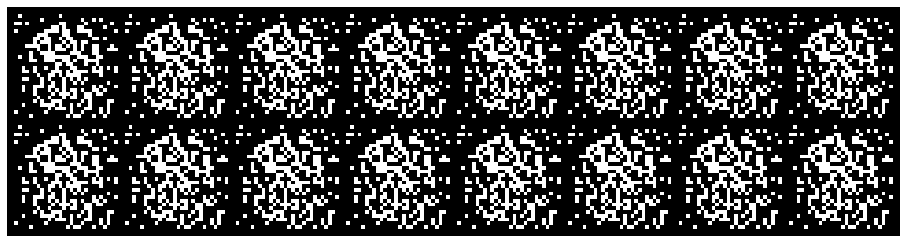

Epoch: 5, Batch Num: [400/600]


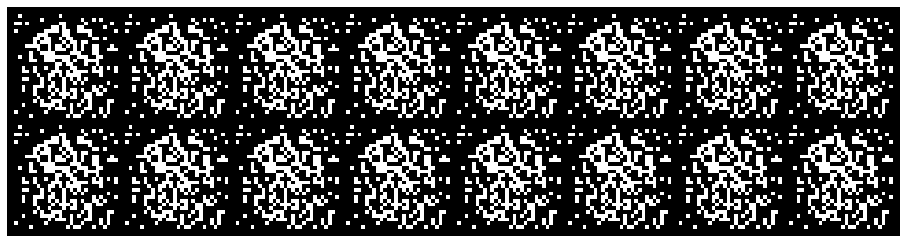

Epoch: 5, Batch Num: [500/600]


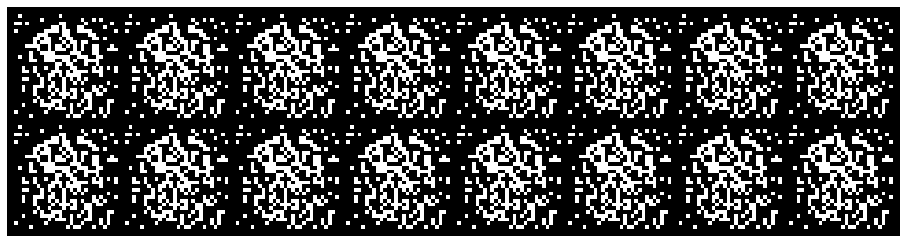

Epoch: 6, Batch Num: [0/600]


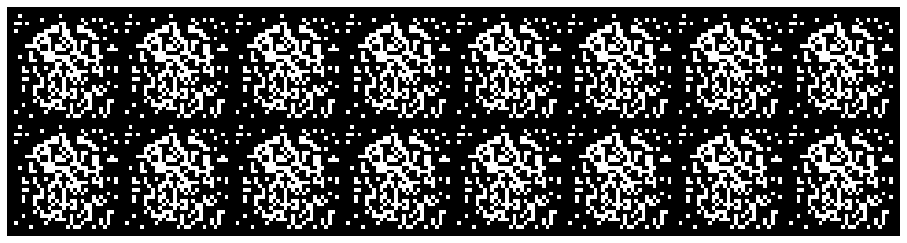

Epoch: 6, Batch Num: [100/600]


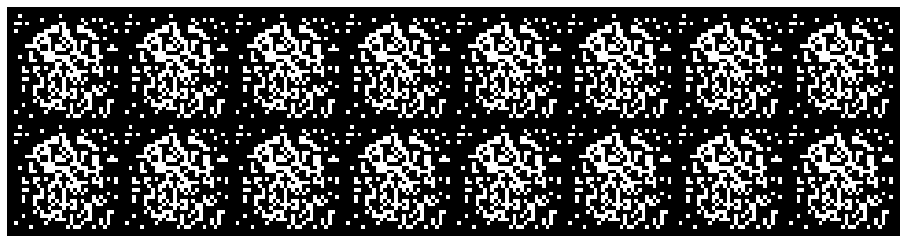

Epoch: 6, Batch Num: [200/600]


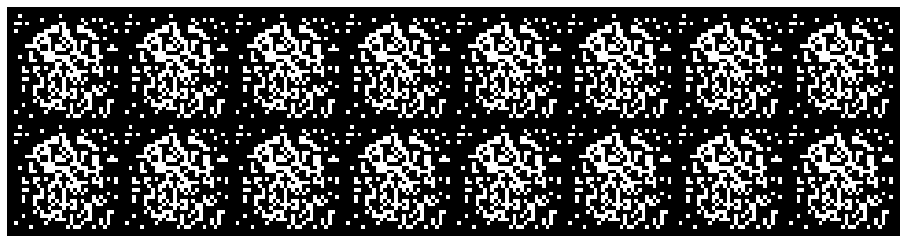

Epoch: 6, Batch Num: [300/600]


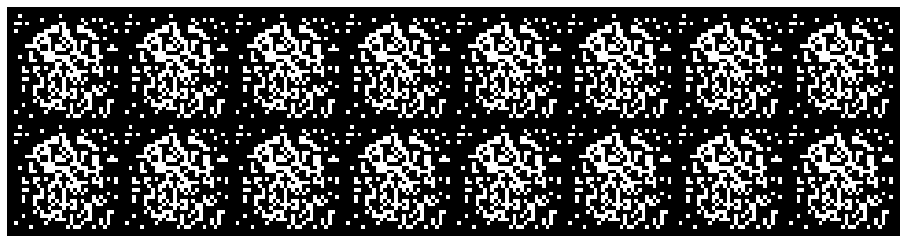

Epoch: 6, Batch Num: [400/600]


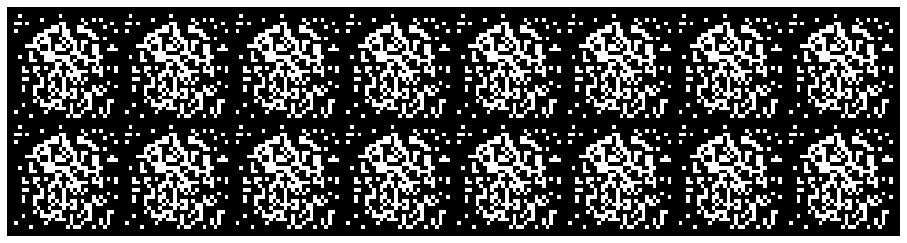

Epoch: 6, Batch Num: [500/600]


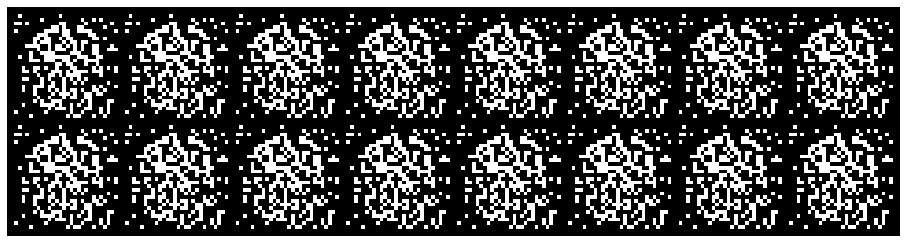

Epoch: 7, Batch Num: [0/600]


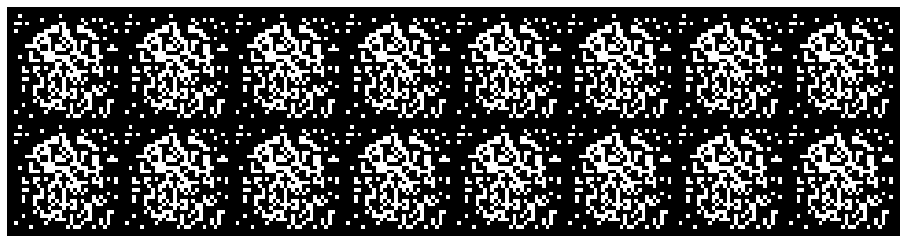

Epoch: 7, Batch Num: [100/600]


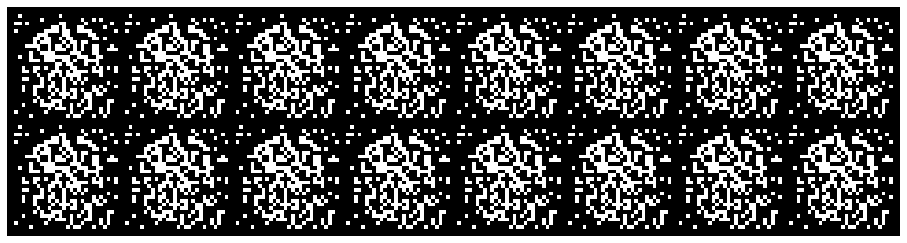

Epoch: 7, Batch Num: [200/600]


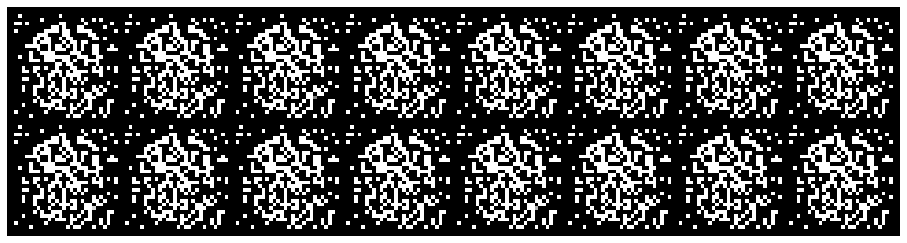

Epoch: 7, Batch Num: [300/600]


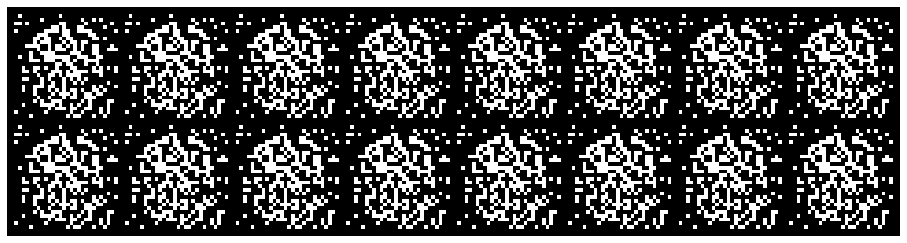

Epoch: 7, Batch Num: [400/600]


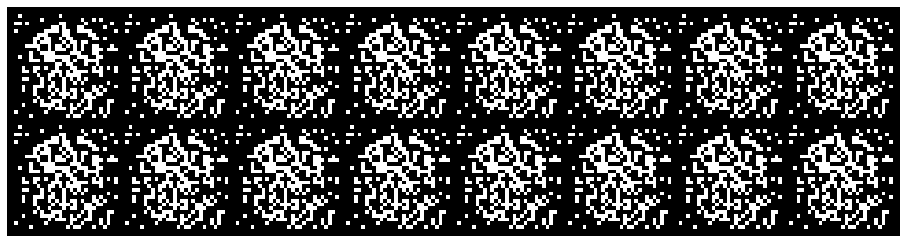

Epoch: 7, Batch Num: [500/600]


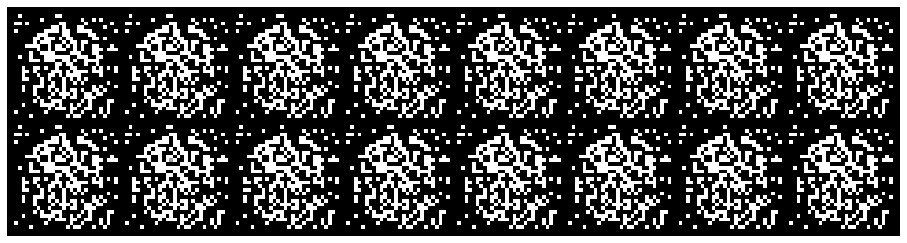

Epoch: 8, Batch Num: [0/600]


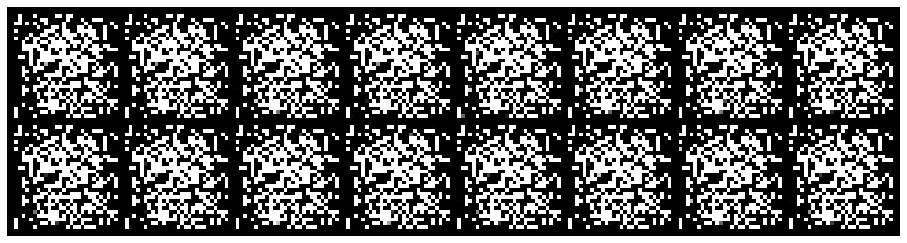

Epoch: 8, Batch Num: [100/600]


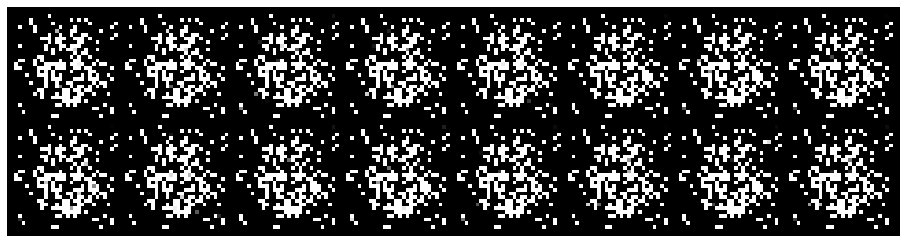

Epoch: 8, Batch Num: [200/600]


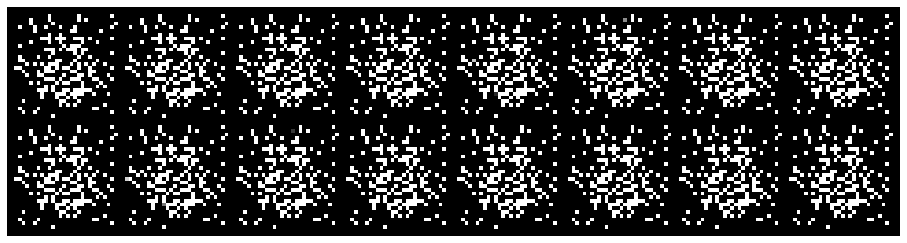

Epoch: 8, Batch Num: [300/600]


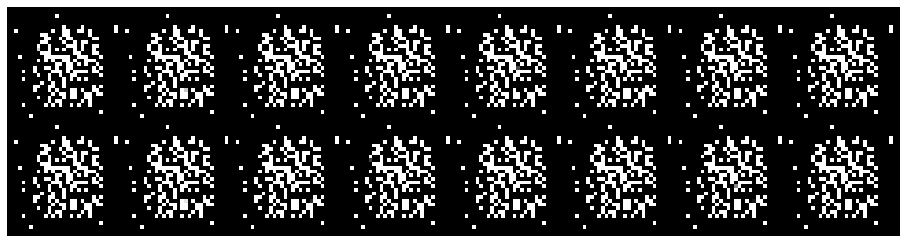

Epoch: 8, Batch Num: [400/600]


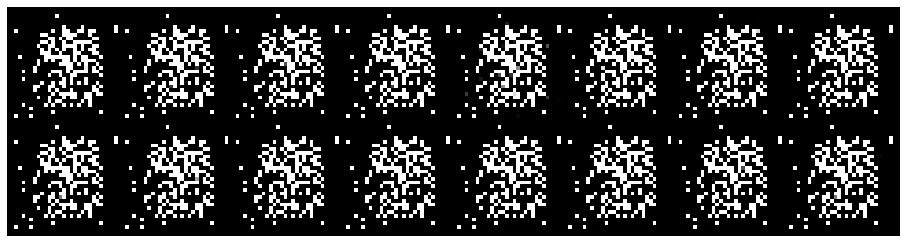

Epoch: 8, Batch Num: [500/600]


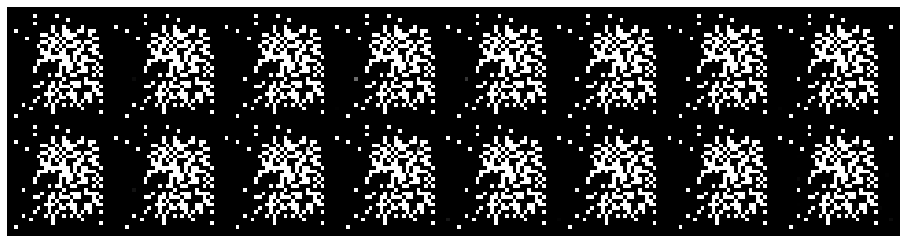

Epoch: 9, Batch Num: [0/600]


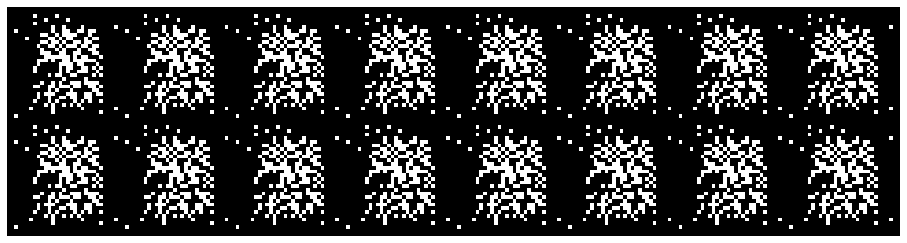

Epoch: 9, Batch Num: [100/600]


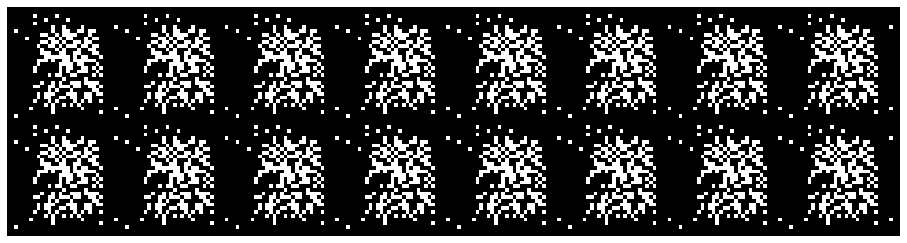

Epoch: 9, Batch Num: [200/600]


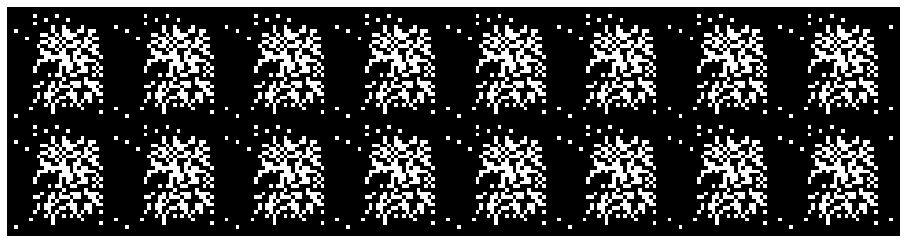

Epoch: 9, Batch Num: [300/600]


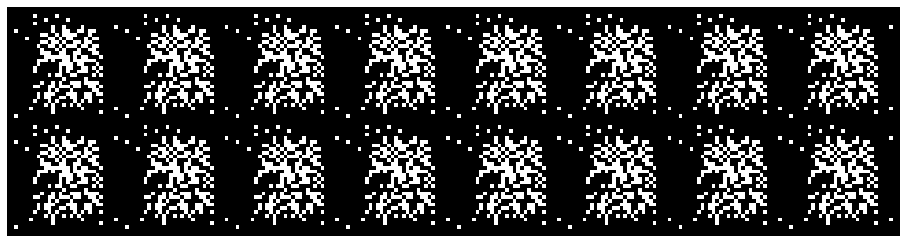

Epoch: 9, Batch Num: [400/600]


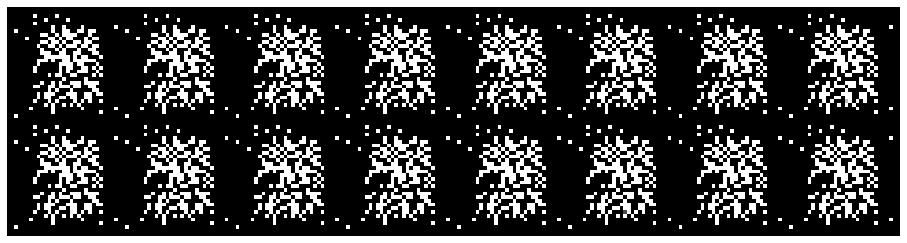

Epoch: 9, Batch Num: [500/600]


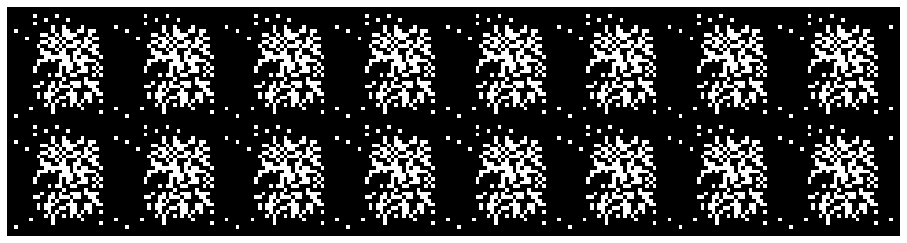

Epoch: 10, Batch Num: [0/600]


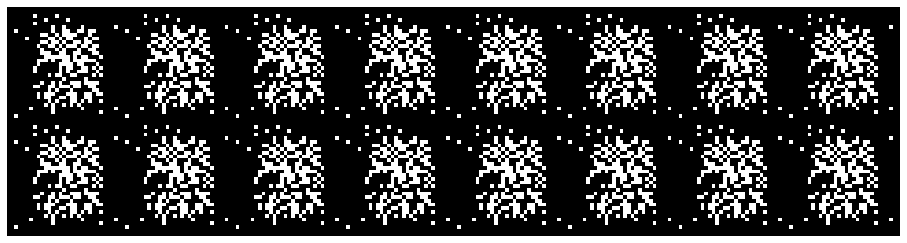

Epoch: 10, Batch Num: [100/600]


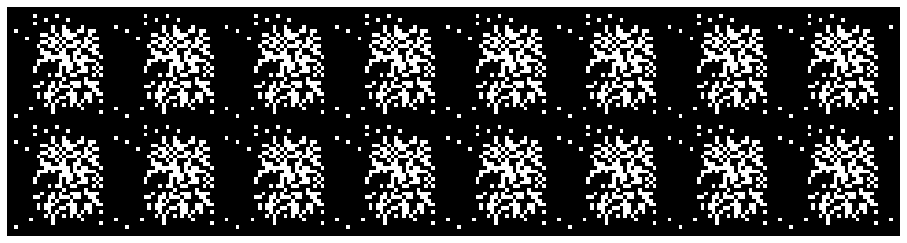

Epoch: 10, Batch Num: [200/600]


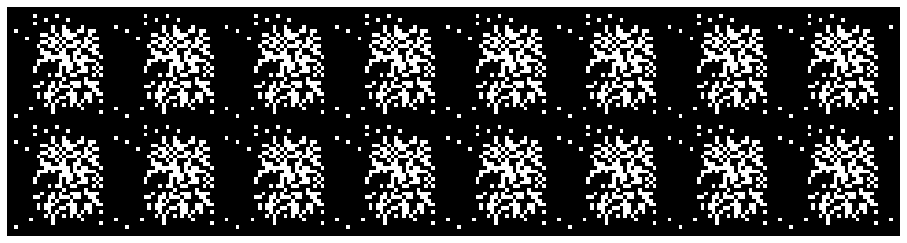

Epoch: 10, Batch Num: [300/600]


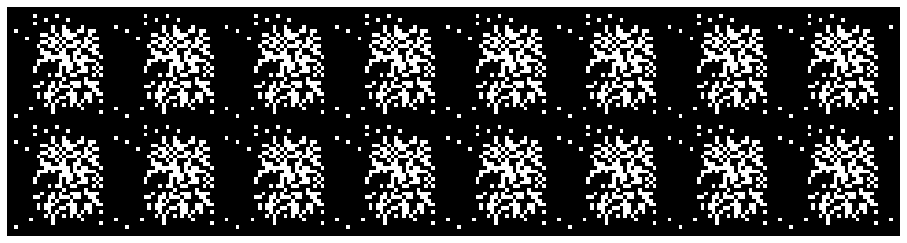

Epoch: 10, Batch Num: [400/600]


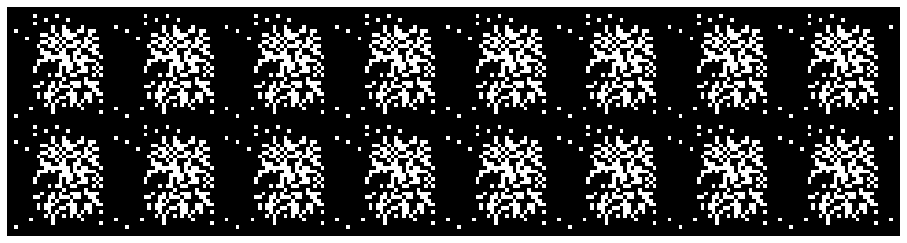

Epoch: 10, Batch Num: [500/600]


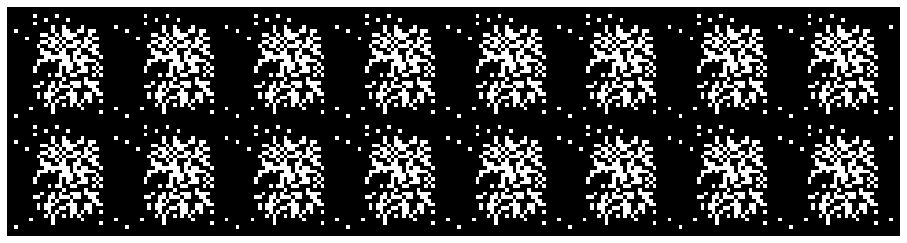

Epoch: 11, Batch Num: [0/600]


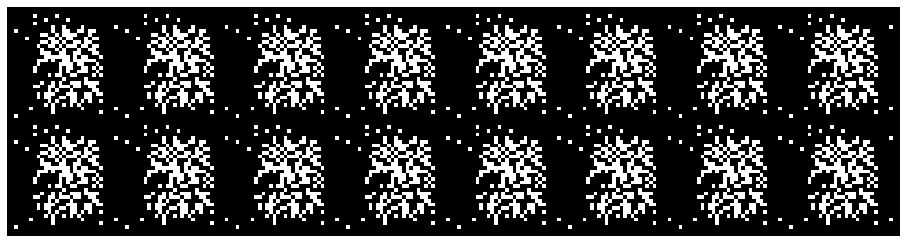

Epoch: 11, Batch Num: [100/600]


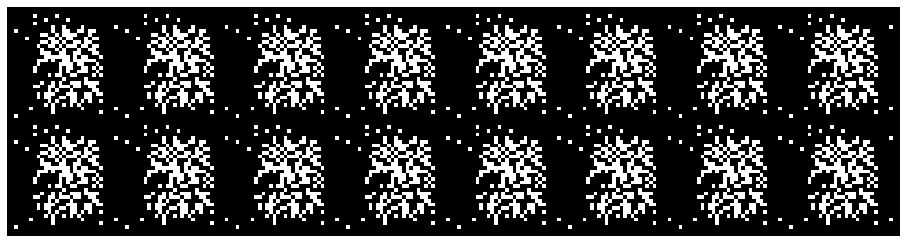

Epoch: 11, Batch Num: [200/600]


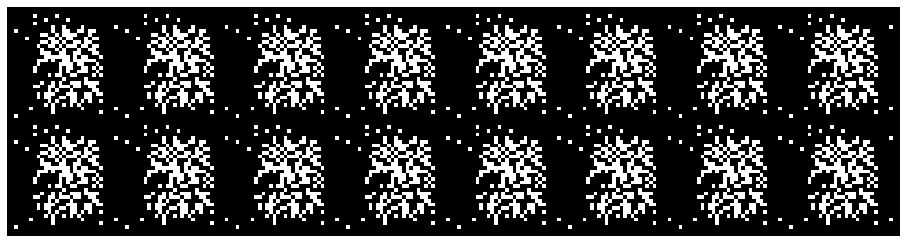

Epoch: 11, Batch Num: [300/600]


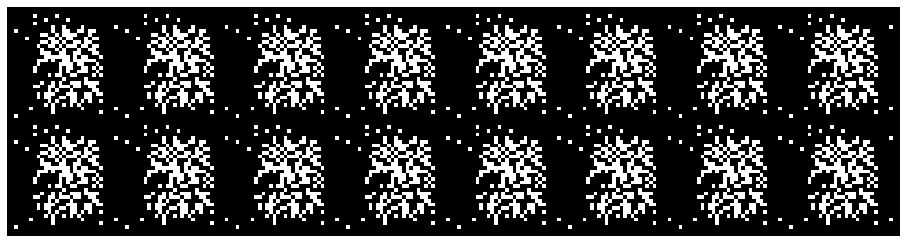

Epoch: 11, Batch Num: [400/600]


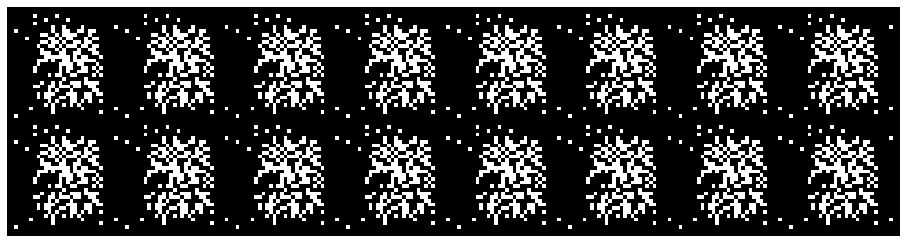

Epoch: 11, Batch Num: [500/600]


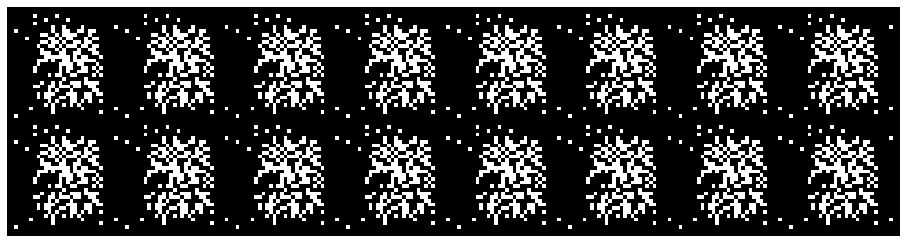

Epoch: 12, Batch Num: [0/600]


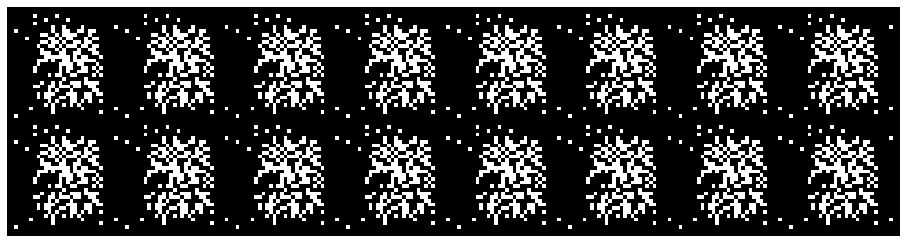

Epoch: 12, Batch Num: [100/600]


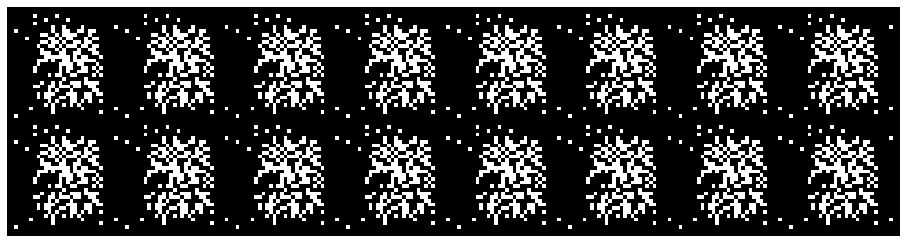

Epoch: 12, Batch Num: [200/600]


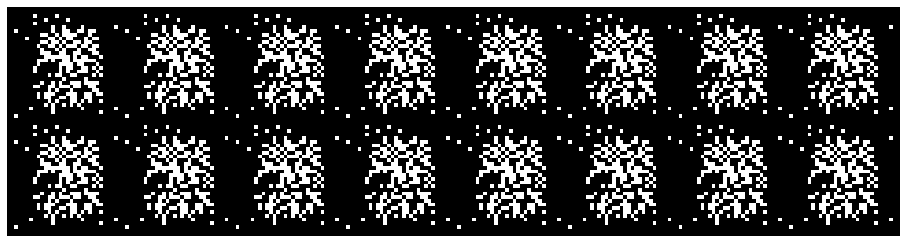

Epoch: 12, Batch Num: [300/600]


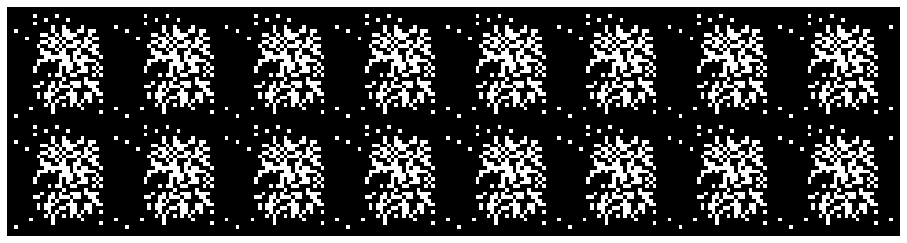

Epoch: 12, Batch Num: [400/600]


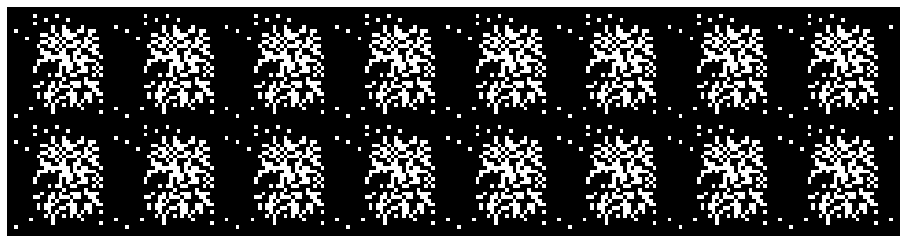

Epoch: 12, Batch Num: [500/600]


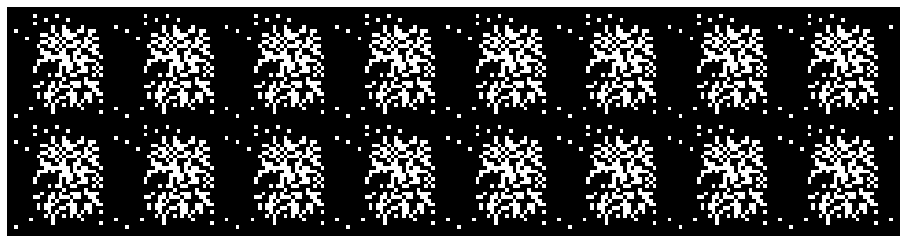

Epoch: 13, Batch Num: [0/600]


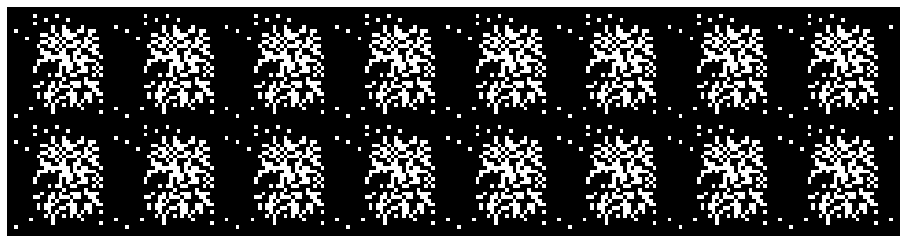

Epoch: 13, Batch Num: [100/600]


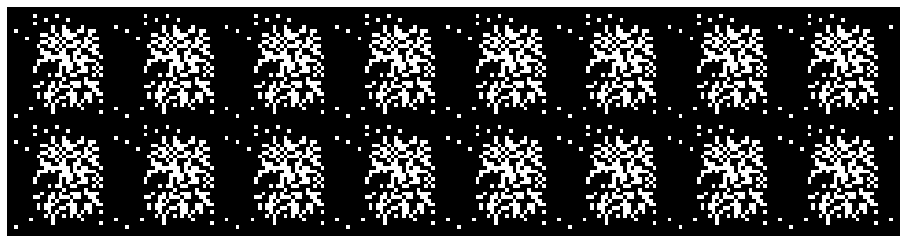

Epoch: 13, Batch Num: [200/600]


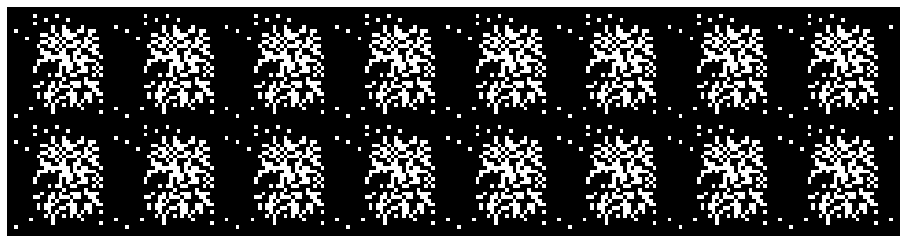

Epoch: 13, Batch Num: [300/600]


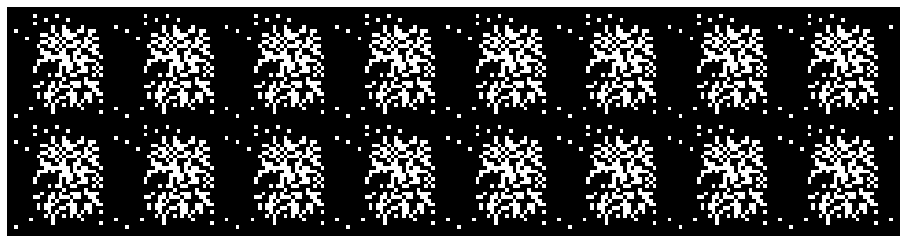

Epoch: 13, Batch Num: [400/600]


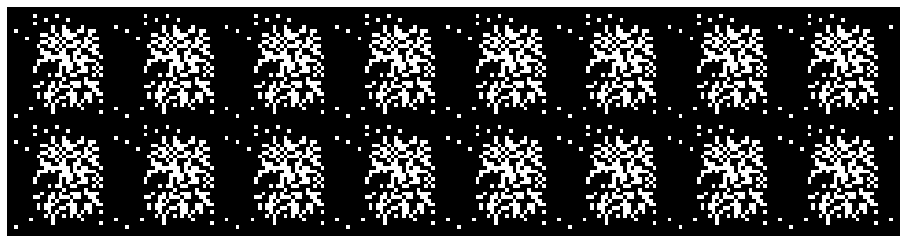

Epoch: 13, Batch Num: [500/600]


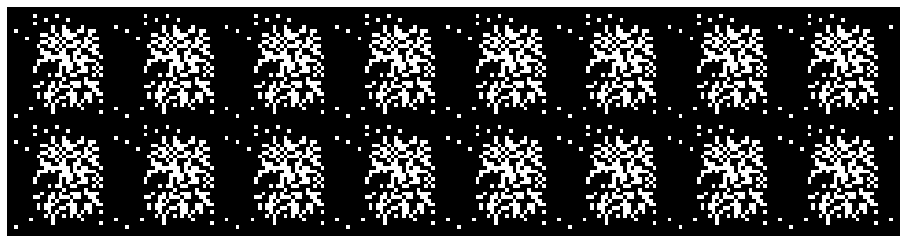

Epoch: 14, Batch Num: [0/600]


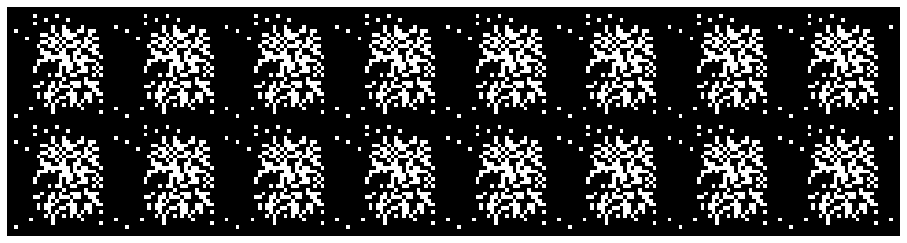

Epoch: 14, Batch Num: [100/600]


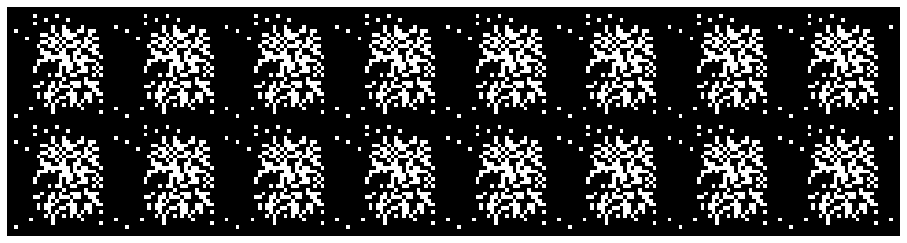

Epoch: 14, Batch Num: [200/600]


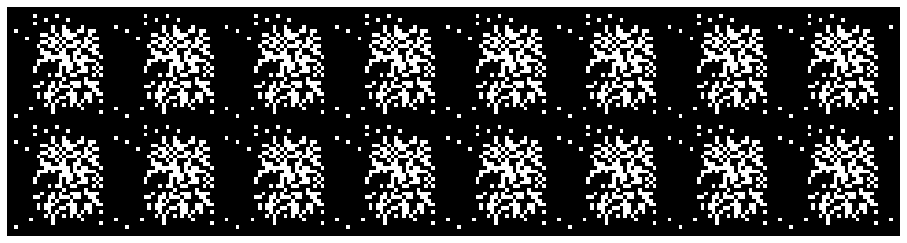

Epoch: 14, Batch Num: [300/600]


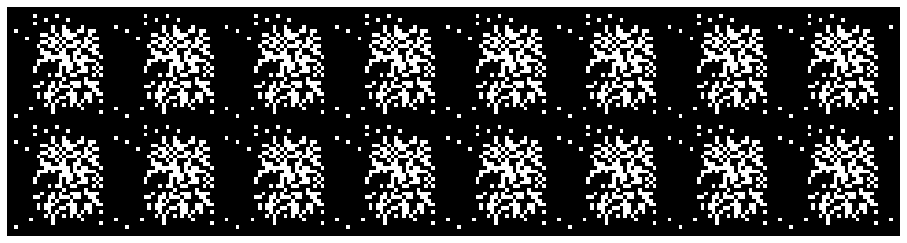

Epoch: 14, Batch Num: [400/600]


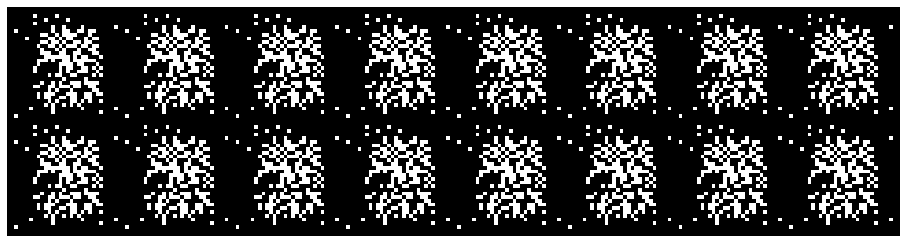

Epoch: 14, Batch Num: [500/600]


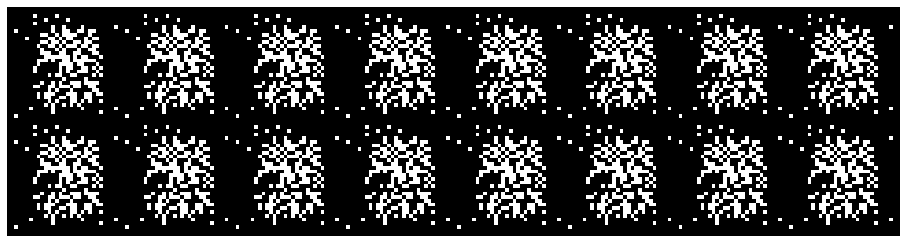

Epoch: 15, Batch Num: [0/600]


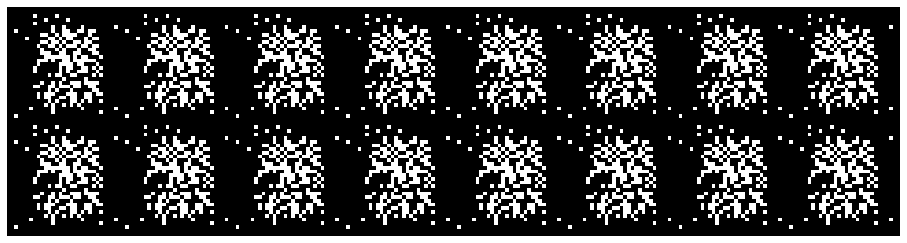

Epoch: 15, Batch Num: [100/600]


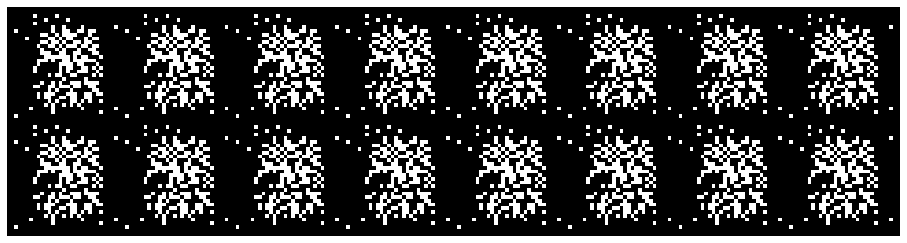

Epoch: 15, Batch Num: [200/600]


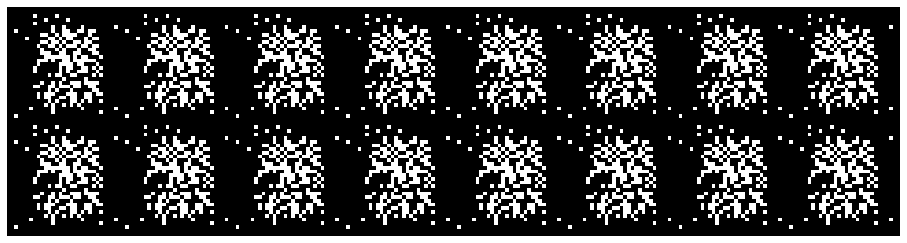

Epoch: 15, Batch Num: [300/600]


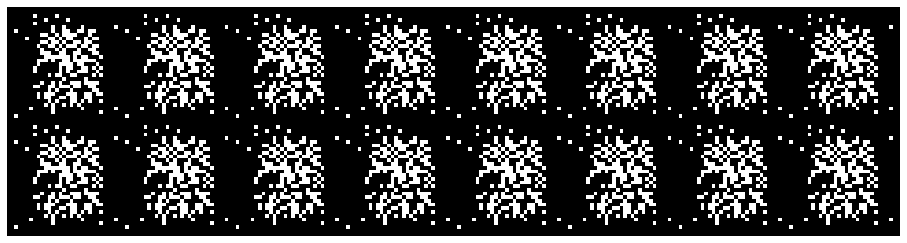

Epoch: 15, Batch Num: [400/600]


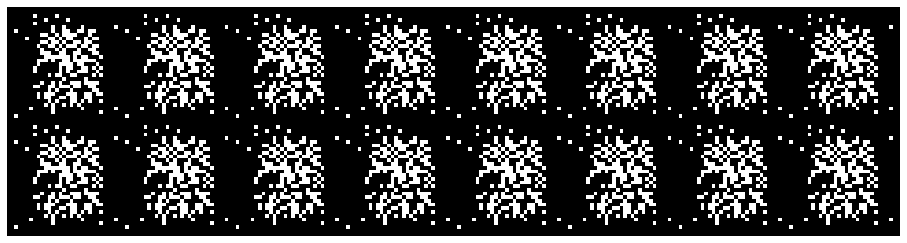

Epoch: 15, Batch Num: [500/600]


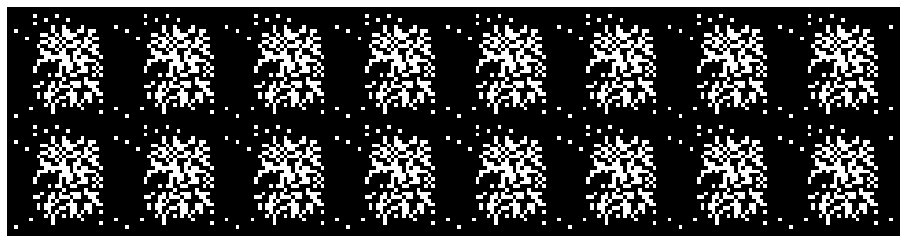

Epoch: 16, Batch Num: [0/600]


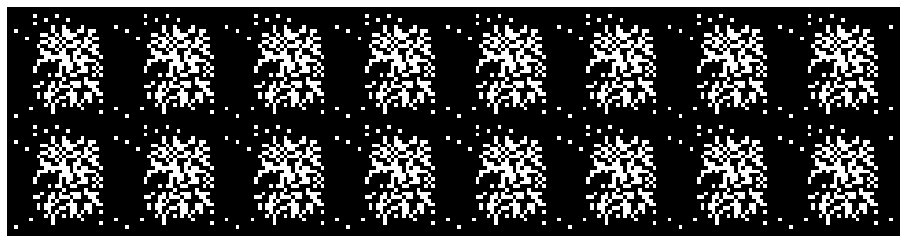

Epoch: 16, Batch Num: [100/600]


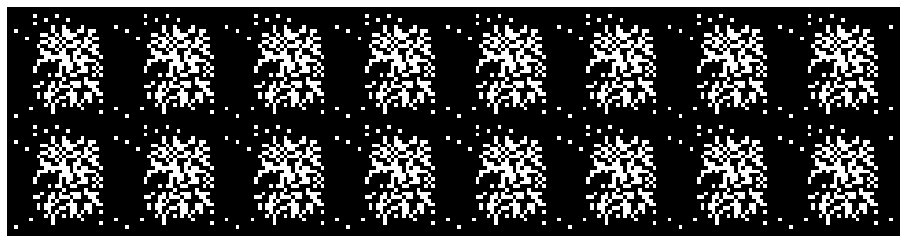

Epoch: 16, Batch Num: [200/600]


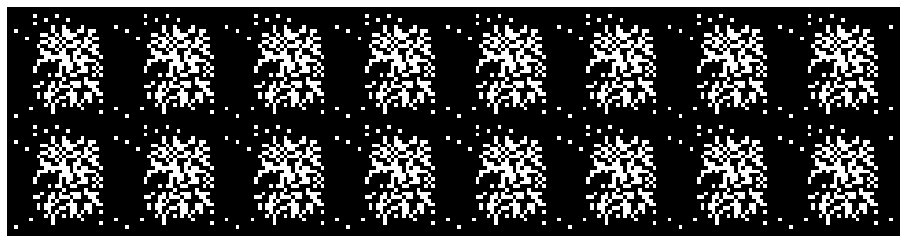

Epoch: 16, Batch Num: [300/600]


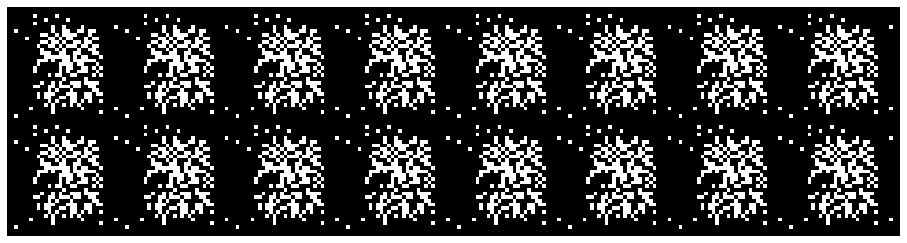

Epoch: 16, Batch Num: [400/600]


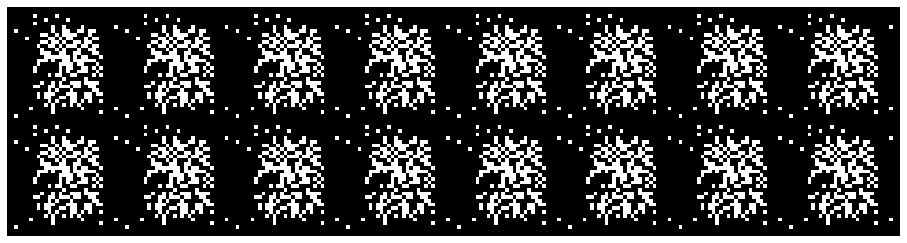

Epoch: 16, Batch Num: [500/600]


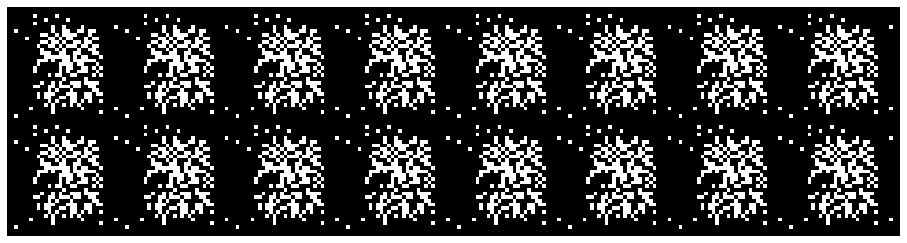

Epoch: 17, Batch Num: [0/600]


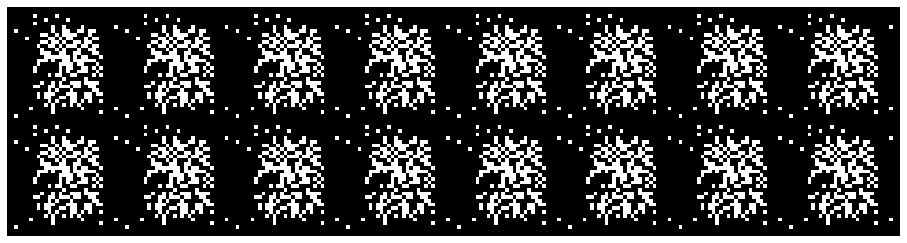

Epoch: 17, Batch Num: [100/600]


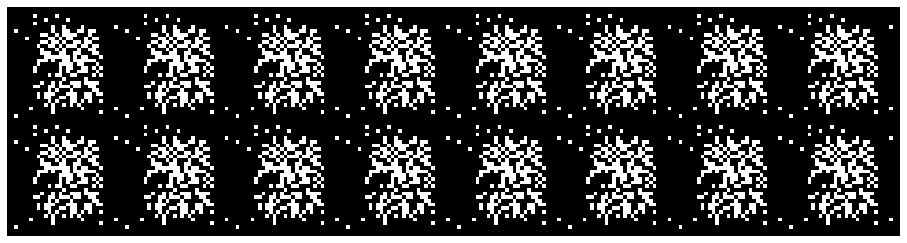

Epoch: 17, Batch Num: [200/600]


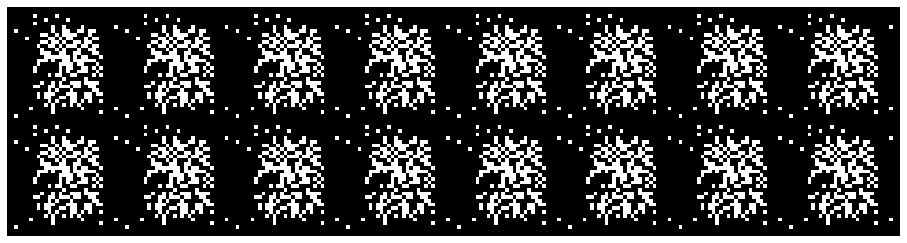

Epoch: 17, Batch Num: [300/600]


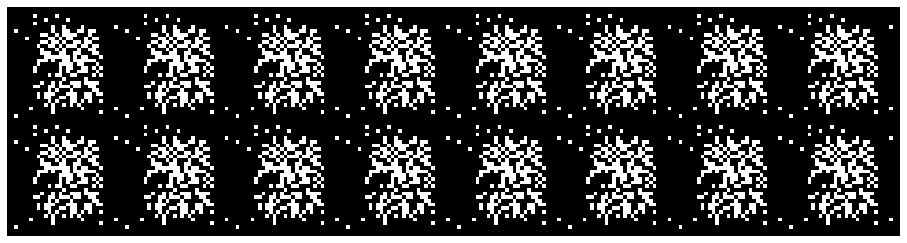

Epoch: 17, Batch Num: [400/600]


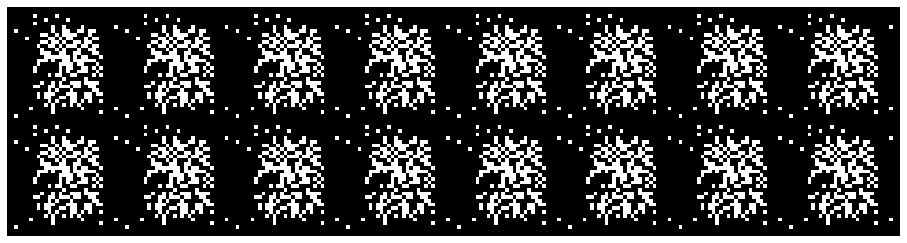

Epoch: 17, Batch Num: [500/600]


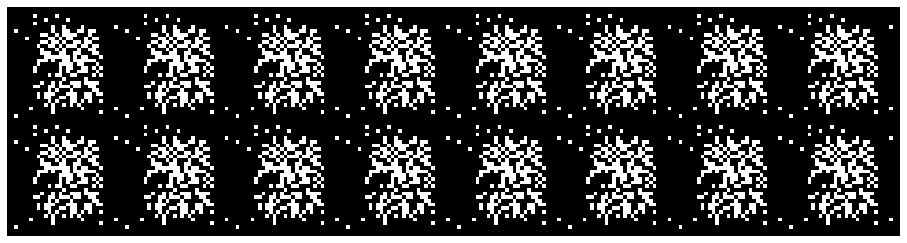

Epoch: 18, Batch Num: [0/600]


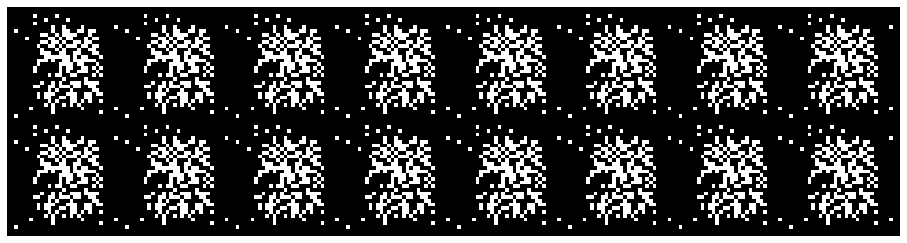

Epoch: 18, Batch Num: [100/600]


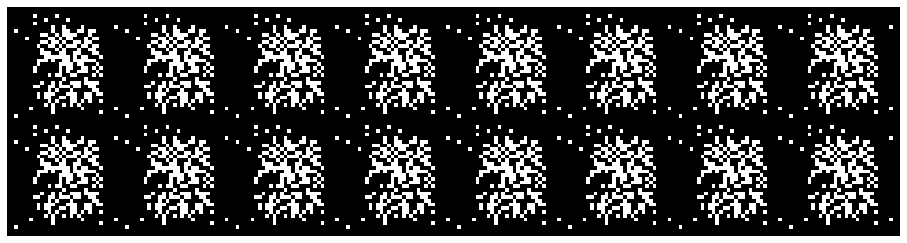

Epoch: 18, Batch Num: [200/600]


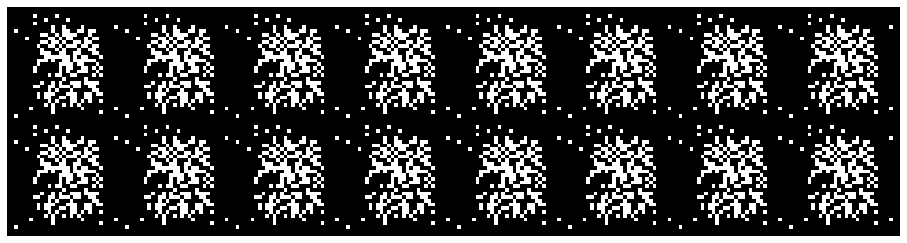

Epoch: 18, Batch Num: [300/600]


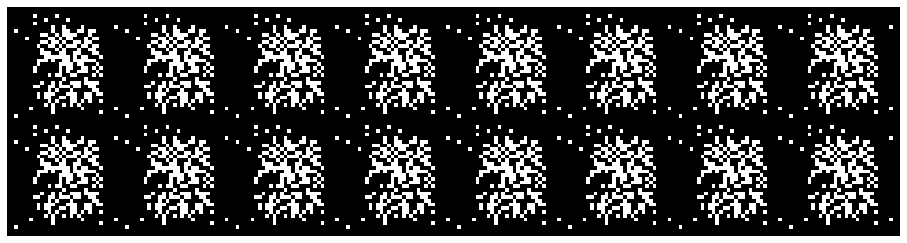

Epoch: 18, Batch Num: [400/600]


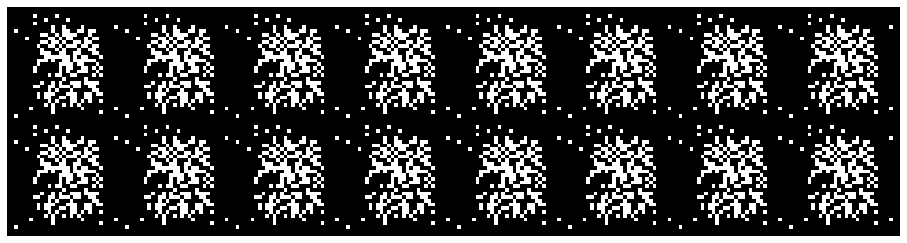

Epoch: 18, Batch Num: [500/600]


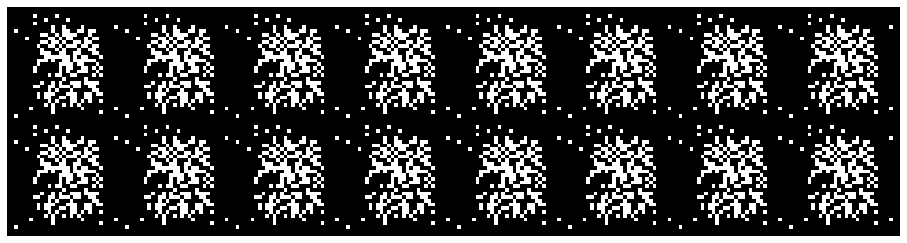

Epoch: 19, Batch Num: [0/600]


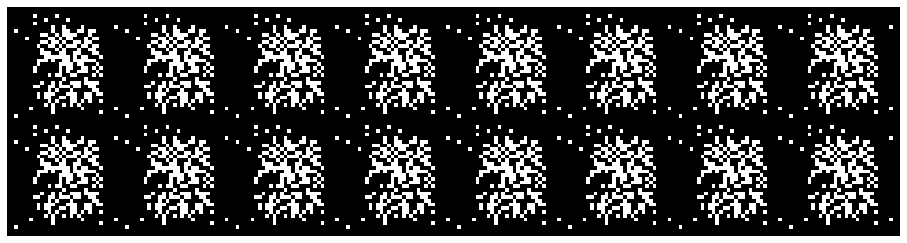

Epoch: 19, Batch Num: [100/600]


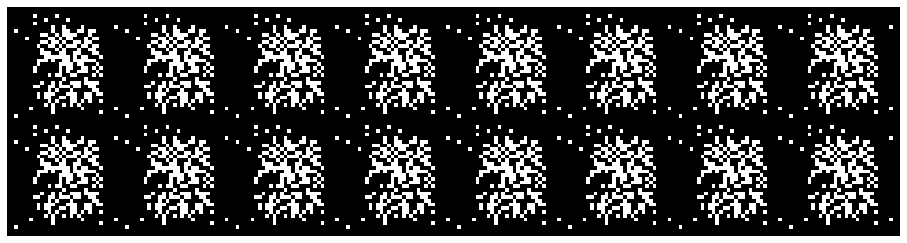

Epoch: 19, Batch Num: [200/600]


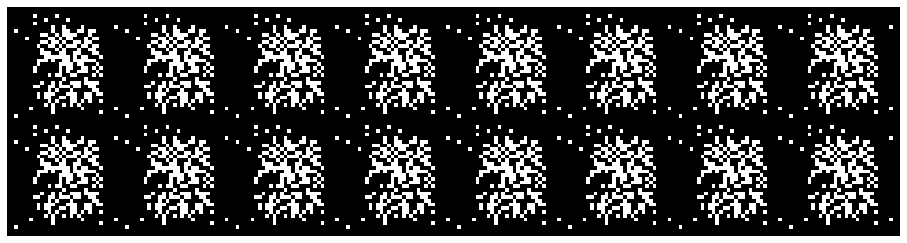

Epoch: 19, Batch Num: [300/600]


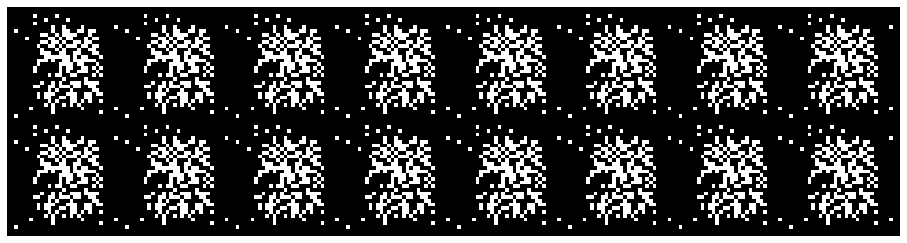

Epoch: 19, Batch Num: [400/600]


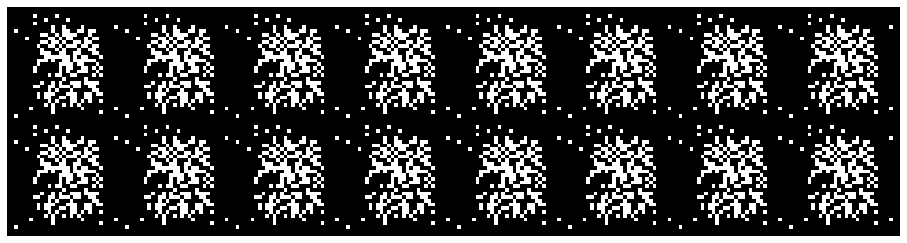

Epoch: 19, Batch Num: [500/600]


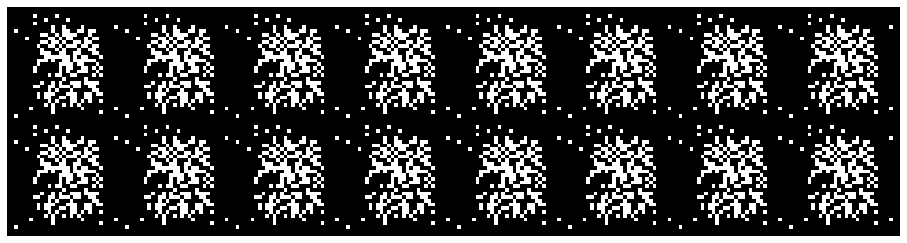

In [25]:
for epoch in range(20):
    for n_batch, (real_batch,_) in enumerate(data_loader):

        # 1 Train Discriminator
        # 1.1 Prepare real data
        real_data = Variable(gt.images_to_vectors(real_batch))
        if torch.cuda.is_available(): real_data = real_data.cuda()
            
        # 1.2 Generate fake data with the Generator
        """ A COMPLETER : Créer des vecteurs bruit """
        noise = gt.noise(100)

        """ A COMPLETER : Générer des images avec le générateur """
        fake_data = generator_new(noise)
        
        # 1.3 Train Discriminator 
        """ A COMPLETER : Entrainer le discriminateur """
        train_discriminator_new(d_optimizer_new, real_data, fake_data)
 
        # 2 Train Generator
        # 2.1 Generate noise
        """  A COMPLETER : Créer des vecteurs bruit à nouveau """
        noise = gt.noise(100)
                      
        # 2.2 Train Generator
        """  A COMPLETER : Entrainer le generateur """
        train_generator_new(g_optimizer_new, generator_new(noise))
                              
        # Generate images from a fixed noise input and visualize the output
        gt.plot_gan(epoch, n_batch, num_batches, generator_new)

Quand on enlève les couches cachées dans le discriminateur, on constate que les résultats sont pires que dans le cas précédent.